**Name: Osama Sidahmed**

**Capstone project: Detecting and Predicting Seizure Onset**

**Date Submitted: 11 Apr 2021**

**Notebook: 4_Modelling_Prediction**

**Notebook order: 4/4**

**Preceding notebooks: `1_Initial_EDA`, `2_Features_Extraction` and `3_Modelling_Detection`**

#  Introduction

So far features have been extracted to the frequency domain and initial modeling for the detection problem has been conducted as well optimization on these models. This notebook takes the predicition problem only in an attempt to optimize a working model using different Neural networks hyper parameters. Dataset_2 is the dataset used on this notebook and on the next notebook.

As an approach as to how to classify the prediction problem, everything that happened before the last three minutes preceding the seizure is considered as class 0 while class 1 is represented by the last three miutes before the seizure onset.

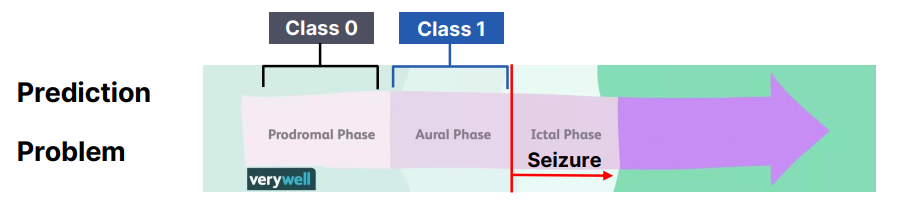

**The idea is to mark the preictal period after which a model is run to attempt detecting the preictal phase while it is forming, ie treating the prediction problem as a detection problem of the preictal phase.**

So far features have been extracted to the frequency domain and initial modeling for the detection problem has been conducted as well optimization on these models. This notebook takes the predicition problem only in an attempt to optimize a working model using different Neural networks hyper parameters. Dataset_2 is the dataset used on this notebook and on the next notebook.

As an approach as to how to classify the detection problem, everything that happens before the seizure has started or after the seizure has finished is considered as class 0 while class 1 is represented by the seizure event.

The Nueral networks models have been optimized manually using a combination of few hyper parameters, changing one or two at time. The hyper-parameters controlled are:
- The number of hidden layers.
- The number of neurons in the hidden layers.
- Regularization value.
- Hidden layers activation methods.
- The model optimizer.
- The number of epochs.

The validation set was passed when the models were fit to assess the model performance during fitting.

In addition to the accuracy metric, the Recall, Precision and confusion matrix metrics where being monitored during fitting to assess the model performance. This were very helpful to assess the best model as we will see. It was decided to optimize the models manually to have a direct control to stop the model based on the train and val metrics performance.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# %matplotlib

import mne

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# Helper function to notify me once a long code block execution is finished
import winsound
'''
Helper function to hengepeep once called
'''
def peep_me():
    winsound.Beep(frequency=2500, duration=500)

 # Modelling

At this stage, some modeling has been done on the prediction problem the code of which has is not included in this notebook, but it is worth summarizing the efforts done.
- SVM models were run on the data to solve the prediction problem. SVM models are very popular between this subject matter researchers, thus they were tried. Different kernels were employed to solve the learning, however, the focus was only to model each patient separately, in other words, it was more of a patient-specific modeling exercise. The results were good for most of the models but it was not well optimized as the idea of the patient-specific modeling was later given up.
- Modelling with three classes was also been done where the third class is the seizure class but the results were very poor, so the focus was dedicated to the two-classes modeling only.
- SVM with the two-classes prediction problem was attempted but the results were not as satisfactory.

This notebook includes the code and results for optimizing neural network models for the prediction problem. tow main approach with regards to features was followed:
- The first one is using the same set of features used on the detection problem, meaning that every observation includes the frequency domain features for the subject epoch and the epoch preceding it, this results in 1,150 features.
- The second approach - that we will see later on this notebook - is using a set of features belonging to the subject epoch in addition to the same features belonging to the previous 4 epochs instead of two only, this results in 2,300 features. The purpose of doing so was to increase the impact of the secular trend in data to reduce any potential misclassifications.

Before modeling, the csv file needs to be relabled so that the label of the epochs falling on the three minutes before each seizure onset as class 1.  

This mask does just that, ie finding the indexs where the sizeure happens.

In [ ]:
mask = (df['target'] ==1) & (df.shift(periods=1)['target'] == 0)

In [ ]:
df[mask].index # passes a list with all siezure onsets on that file

The function below takes the individual files pertaining to single patients and relabel them so that now all epochs falling in the time period of 3 minutes before the seizure onset is labeled as our positive class. 

In [ ]:
def preictal_annotation(input_directory_, output_directory_, t_epoch_, t_preictal_):
    '''
    The function writes to disk a csv file after it is relabled
    Input:
        input_directory_: input directory + file
        output_directory_: output directory + file
        t_epoch_
        t_preictal_: preictal time in minutes - This is how long before the seizure onset we consider epochs as class 1 

    output:
        file written to the new directory
    '''
    n_epochs = t_preictal_ * 60 / t_epoch_
    patients_dict = {'0':'chb01','1':'chb06','2':'chb10','3':'chb13','4':'chb14','5':'chb15','6':'chb16',
                 '7':'chb19', '8':'chb20','9':'chb21','10':'chb23','11':'chb24'}
    
    for key, value in patients_dict.items():

        # Read the file and store in a dataframe
        print(f'Reading file for patient >> {value} <<....................', end='\r')

        # Read csv file containig the database annotations and store into dataframe
        df = pd.read_csv(input_directory_ + '/' + 'seizure_w_ds2_3s_' + value +'_full.csv')
        mask = (df['target'] ==1) & (df.shift(periods=1)['target'] == 0)

        # apply relabeling of the preictal period
        print(f'Labeling patient >> {value} << file .......................', end='\r')

        for i in df[mask].index:
            for j in np.arange(1,n_epochs+1):
                if i-j > 2: # if too close to the begining of the file
                    index = i-j
                    df.loc[index,'target'] = 2

        # Write file to disk as a csv file
        print(f'Writing file for patient >> {value} << to disk.............', end='\r')

        df.to_csv(output_directory_ + '/' + 'seizure_w_ds2_3s_' + value +'_full_preictal.csv')
    peep_me()
    print(f'Finished.......................................', end='\r') 

    peep_me()

Implement the funcion to relable all patients data:

In [ ]:
input_directory_ = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files'
output_directory_ = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3'
t_epoch_ = 3
t_preictal_= 3

preictal_annotation(input_directory_, output_directory_, t_epoch_, t_preictal_)

3min Preictal files for 3 sec epochs.

In [ ]:
input_directory_ = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files'
output_directory_ = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_5'
t_epoch_ = 3
t_preictal_= 3

preictal_annotation(input_directory_, output_directory_, t_epoch_, t_preictal_)

Different minutes were tried namely 5 and 10, a sample haven compared to the 3 minutes plot, the latter showed more PCA class separation.

The following code block takes all the files resulting from the previous operation and concatenates them all into one file. then everything after the seizure onset is deleted from the file and all epochs falling within 3 minutes before the seizure starts are labeled as class 1, then the file is saved to disk. 

In [ ]:
import glob

path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3'

all_files = glob.glob(path + "/*preictal.csv")
df_seizure = pd.concat((pd.read_csv(f) for f in all_files))

# Store as one csv file
path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined'
df_seizure.to_csv(path + '/' + 'seizure_w_ds2_3s_full_preictal.csv')

# Read csv file containig the data
path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined'

df_seizure = pd.read_csv(
    path + '/' + 'seizure_w_ds2_3s_full_preictal.csv')

df_seizure_w = df_seizure.loc[:, ~df_seizure.columns.str.contains('^Unnamed')]

# Delete class seizure
mask = (df_seizure_w['target'] == 1)
df_seizure_w = df_seizure_w.drop(df_seizure_w[mask].index)

# Change 2 to 1 
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 2,1, df_seizure_w['target'])

# Store as one csv file
path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined'
df_seizure_w.to_csv(path + '/' + 'seizure_w_ds2_3s_full_preictal_2classes.csv')

In [11]:
# Read csv file containig the data
path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined'

df_seizure_w = pd.read_csv(
    path + '/' + 'seizure_w_ds2_3s_full_preictal_2classes.csv')

In [12]:
df_seizure_w.head(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_seizure_w = df_seizure_w.loc[:, ~df_seizure_w.columns.str.contains('^Unnamed')]
df_seizure_w.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,7.305563e-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_seizure_w['target'].value_counts()

0.0    91930
1.0     4348
Name: target, dtype: int64

In [15]:
df_seizure_w.shape

(96278, 1151)

In [16]:
# Cell 20
# read file

# path = 'data/dataset_2'
# combined_files_path = 'combined_files'

# print(f'Reading file.......................................', end='\r')
# df_seizure_w = pd.read_csv(path + '/' + combined_files_path + '/' + 'seizure_w_ds2_3s_280321_full.csv')


# separate x and y
X = df_seizure_w.drop('target', axis=1)
y = df_seizure_w['target']


# split into train/Val and test before SMOTE
from sklearn.model_selection import train_test_split

print(f'Splitting data into train/Val and test before SMOTE..........', end='\r')
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# split into train and val before SMOTE
print(f'Splitting data into train and val before SMOTE..........', end='\r')
X_train, X_val, y_train, y_val= train_test_split(X_remain, y_remain, test_size=0.2, stratify=y_remain, random_state=1)

import imblearn
from imblearn.over_sampling import SMOTE

print(f'SMOTE operation ...................................................', end='\r')
# 100% SMOTE strategy
strategy = {0.0:y_train.value_counts()[0], 1.0:(y_train.value_counts()[0]).astype(int)}
oversample = SMOTE(sampling_strategy=strategy, random_state = 1)  # 100% oversampling
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

strategy = {0.0:y_val.value_counts()[0], 1.0:(y_val.value_counts()[0]).astype(int)}
oversample = SMOTE(sampling_strategy=strategy, random_state = 1)  # 100% oversampling
X_val_os, y_val_os = oversample.fit_resample(X_val, y_val) #?????????????????????????

# use standard scaler for the first pass
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

print(f'Scaling patient data..................................', end='\r')
# scale data - train + test, first fit
standard_scaler.fit(X_train_os)
X_train_os_ss = standard_scaler.transform(X_train_os)
X_val_os_ss = standard_scaler.transform(X_val_os)
X_test_ss = standard_scaler.transform(X_test)

# PCA first to look at the data - reduce dimensions
from sklearn.decomposition import PCA

print(f'PCA operation on data.........................', end='\r')
# fit and transform
pca = PCA(n_components=X_train_os_ss.shape[1])
pca.fit(X_train_os_ss)  # _ss is scaled data
X_train_os_ss_PCA = pca.transform(X_train_os_ss)
X_val_os_ss_PCA = pca.transform(X_val_os_ss)
X_test_ss_PCA = pca.transform(X_test_ss)

expl_var = pca.explained_variance_ratio_
pca_expl_var = np.cumsum(expl_var)[10]
print(f'pca_expl_var: {pca_expl_var}.........................', end='\r')

# extract the first 11 dimensions only
# fit and transform
pca = PCA(n_components=10)
pca.fit(X_train_os_ss) # _ss is scaled data
X_train_os_ss_PCA10 = pca.transform(X_train_os_ss)
X_val_os_ss_PCA10 = pca.transform(X_val_os_ss)
X_test_ss_PCA10 = pca.transform(X_test_ss)

peep_me()

Start modelling some neural networks:

Model pre-1

In [10]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [26]:
# Fit the model
# Cell 22

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/100
3678/3678 [==============================] - 5s 1ms/step - loss: 0.6409 - tp: 43867.0000 - fp: 29086.0000 - tn: 29749.0000 - fn: 14968.0000 - accuracy: 0.6256 - precision: 0.6013 - recall: 0.7456 - auc: 0.6851 - val_loss: 0.6501 - val_tp: 11550.0000 - val_fp: 7910.0000 - val_tn: 6799.0000 - val_fn: 3159.0000 - val_accuracy: 0.6237 - val_precision: 0.5935 - val_recall: 0.7852 - val_auc: 0.6752
Epoch 2/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6410 - tp: 43545.0000 - fp: 28892.0000 - tn: 29943.0000 - fn: 15290.0000 - accuracy: 0.6245 - precision: 0.6011 - recall: 0.7401 - auc: 0.6847 - val_loss: 0.6622 - val_tp: 10796.0000 - val_fp: 7587.0000 - val_tn: 7122.0000 - val_fn: 3913.0000 - val_accuracy: 0.6091 - val_precision: 0.5873 - val_recall: 0.7340 - val_auc: 0.6626
Epoch 3/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6394 - tp: 44009.0000 - fp: 28987.0000 - tn: 29848.0000 - fn: 14826.0000 - accuracy: 0.6277 - precision: 

3678/3678 [==============================] - 5s 1ms/step - loss: 0.6313 - tp: 43094.0000 - fp: 26539.0000 - tn: 32296.0000 - fn: 15741.0000 - accuracy: 0.6407 - precision: 0.6189 - recall: 0.7325 - auc: 0.7075 - val_loss: 0.6538 - val_tp: 9260.0000 - val_fp: 5697.0000 - val_tn: 9012.0000 - val_fn: 5449.0000 - val_accuracy: 0.6211 - val_precision: 0.6191 - val_recall: 0.6295 - val_auc: 0.6849
Epoch 42/100
3678/3678 [==============================] - 5s 1ms/step - loss: 0.6311 - tp: 43249.0000 - fp: 26600.0000 - tn: 32235.0000 - fn: 15586.0000 - accuracy: 0.6415 - precision: 0.6192 - recall: 0.7351 - auc: 0.7082 - val_loss: 0.6568 - val_tp: 10803.0000 - val_fp: 7173.0000 - val_tn: 7536.0000 - val_fn: 3906.0000 - val_accuracy: 0.6234 - val_precision: 0.6010 - val_recall: 0.7344 - val_auc: 0.6754
Epoch 43/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6305 - tp: 43229.0000 - fp: 26632.0000 - tn: 32203.0000 - fn: 15606.0000 - accuracy: 0.6410 - precision: 0.6188 - re

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6301 - tp: 43684.0000 - fp: 26861.0000 - tn: 31974.0000 - fn: 15151.0000 - accuracy: 0.6430 - precision: 0.6192 - recall: 0.7425 - auc: 0.7092 - val_loss: 0.6489 - val_tp: 9369.0000 - val_fp: 5482.0000 - val_tn: 9227.0000 - val_fn: 5340.0000 - val_accuracy: 0.6321 - val_precision: 0.6309 - val_recall: 0.6370 - val_auc: 0.6933
Epoch 82/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6278 - tp: 43744.0000 - fp: 26593.0000 - tn: 32242.0000 - fn: 15091.0000 - accuracy: 0.6458 - precision: 0.6219 - recall: 0.7435 - auc: 0.7128 - val_loss: 0.6530 - val_tp: 12351.0000 - val_fp: 8510.0000 - val_tn: 6199.0000 - val_fn: 2358.0000 - val_accuracy: 0.6306 - val_precision: 0.5921 - val_recall: 0.8397 - val_auc: 0.6968
Epoch 83/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6308 - tp: 43530.0000 - fp: 26580.0000 - tn: 32255.0000 - fn: 15305.0000 - accuracy: 0.6440 - precision: 0.6209 - re

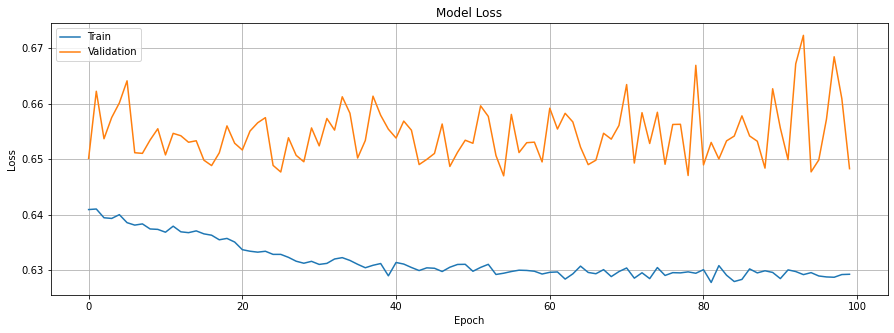

In [27]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

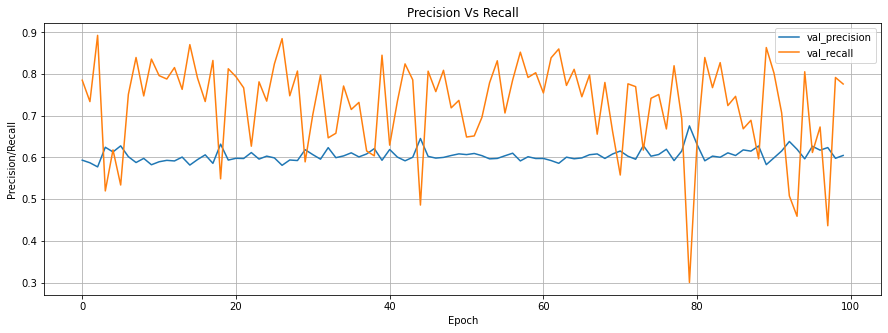

In [28]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [29]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.6447
Test Accuracy: 0.5085
Test Precision: 0.0650
Test Recall: 0.7379
Test AUC: 0.6731
Test TP: 642
Test FP: 9236
Test TN: 9150
Test FN: 228


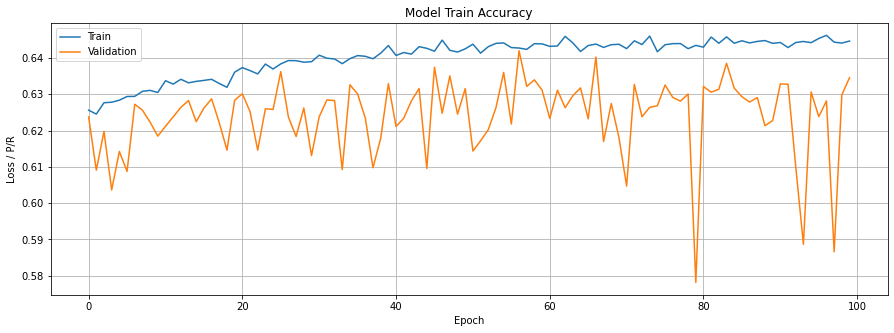

In [30]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Loss / P/R')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [31]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [32]:
def plot_cm(labels, predictions, p=0.525):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.6507999300956726
tp :  642.0
fp :  9236.0
tn :  9150.0
fn :  228.0
accuracy :  0.5085168480873108
precision :  0.06499291211366653
recall :  0.7379310131072998
auc :  0.673143208026886

Non-Seizure Epochs Detected (True Negatives):  9912
Non-Seizure Epochs Incorrectly Detected (False Positives):  8474
Pre-Seizure Epochs Missed (False Negatives):  263
Pre-Seizure Epochs Detected (True Positives):  607
Total Pre-Seizure Epochs:  870


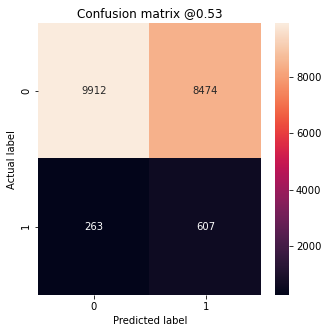

In [33]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The model was run for 100 epochs with adam optimizer, relu, and 3 simple layers, the model started with high val loss and the val accuracy started to become erratic from epoch 70  onwards. Accuracy and precision scores for this model are low and it misclassifies a lot of the negative class. We need to optimize the structure, the optimizer, and the activation function.

--------------------------------

Now Try to do the same Dense network with weighted parameter and no SMOTE.

Calculate class weights

In [17]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg = df_seizure_w['target'].value_counts()[0]
pos = df_seizure_w['target'].value_counts()[1]
total = neg + pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 11.07


Model pre-2

In [18]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

weighted_model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
weighted_model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
weighted_model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

weighted_model.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
weighted_model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

weighted_model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer)) 
weighted_model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

# Declare the output layer
weighted_model.add(layers.Dense(1, activation="sigmoid"))

weighted_model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [19]:
# Fit the model

# Train the model
weighted_history = weighted_model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=50, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os),
                    # The class weights go here
                    class_weight=class_weight) 

peep_me()

Epoch 1/50
3678/3678 [==============================] - 8s 2ms/step - loss: 1.1529 - tp: 58711.0000 - fp: 58137.0000 - tn: 698.0000 - fn: 124.0000 - accuracy: 0.5049 - precision: 0.5025 - recall: 0.9979 - auc: 0.5711 - val_loss: 1.5893 - val_tp: 14694.0000 - val_fp: 14510.0000 - val_tn: 199.0000 - val_fn: 15.0000 - val_accuracy: 0.5063 - val_precision: 0.5032 - val_recall: 0.9990 - val_auc: 0.6100
Epoch 2/50
3678/3678 [==============================] - 7s 2ms/step - loss: 1.0547 - tp: 58828.0000 - fp: 57955.0000 - tn: 880.0000 - fn: 7.0000 - accuracy: 0.5074 - precision: 0.5037 - recall: 0.9999 - auc: 0.6034 - val_loss: 1.5232 - val_tp: 14692.0000 - val_fp: 14479.0000 - val_tn: 230.0000 - val_fn: 17.0000 - val_accuracy: 0.5072 - val_precision: 0.5037 - val_recall: 0.9988 - val_auc: 0.6156
Epoch 3/50
3678/3678 [==============================] - 8s 2ms/step - loss: 1.0366 - tp: 58829.0000 - fp: 57779.0000 - tn: 1056.0000 - fn: 6.0000 - accuracy: 0.5089 - precision: 0.5045 - recall: 0.999

3678/3678 [==============================] - 7s 2ms/step - loss: 1.0038 - tp: 58798.0000 - fp: 56130.0000 - tn: 2705.0000 - fn: 37.0000 - accuracy: 0.5227 - precision: 0.5116 - recall: 0.9994 - auc: 0.6603 - val_loss: 1.4616 - val_tp: 14694.0000 - val_fp: 14111.0000 - val_tn: 598.0000 - val_fn: 15.0000 - val_accuracy: 0.5198 - val_precision: 0.5101 - val_recall: 0.9990 - val_auc: 0.6574
Epoch 22/50
3678/3678 [==============================] - 8s 2ms/step - loss: 1.0013 - tp: 58794.0000 - fp: 55846.0000 - tn: 2989.0000 - fn: 41.0000 - accuracy: 0.5251 - precision: 0.5129 - recall: 0.9993 - auc: 0.6607 - val_loss: 1.4064 - val_tp: 14678.0000 - val_fp: 14004.0000 - val_tn: 705.0000 - val_fn: 31.0000 - val_accuracy: 0.5229 - val_precision: 0.5117 - val_recall: 0.9979 - val_auc: 0.6609
Epoch 23/50
3678/3678 [==============================] - 8s 2ms/step - loss: 1.0024 - tp: 58796.0000 - fp: 56167.0000 - tn: 2668.0000 - fn: 39.0000 - accuracy: 0.5223 - precision: 0.5114 - recall: 0.9993 - au

3678/3678 [==============================] - 8s 2ms/step - loss: 0.9964 - tp: 58788.0000 - fp: 55446.0000 - tn: 3389.0000 - fn: 47.0000 - accuracy: 0.5284 - precision: 0.5146 - recall: 0.9992 - auc: 0.6701 - val_loss: 1.4746 - val_tp: 14668.0000 - val_fp: 13842.0000 - val_tn: 867.0000 - val_fn: 41.0000 - val_accuracy: 0.5281 - val_precision: 0.5145 - val_recall: 0.9972 - val_auc: 0.6645
Epoch 42/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.9974 - tp: 58780.0000 - fp: 55479.0000 - tn: 3356.0000 - fn: 55.0000 - accuracy: 0.5281 - precision: 0.5144 - recall: 0.9991 - auc: 0.6693 - val_loss: 1.4571 - val_tp: 14671.0000 - val_fp: 14147.0000 - val_tn: 562.0000 - val_fn: 38.0000 - val_accuracy: 0.5178 - val_precision: 0.5091 - val_recall: 0.9974 - val_auc: 0.6594
Epoch 43/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.9951 - tp: 58786.0000 - fp: 55387.0000 - tn: 3448.0000 - fn: 49.0000 - accuracy: 0.5289 - precision: 0.5149 - recall: 0.9992 - au

In [20]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    plt.subplots(2,2, figsize=(12,12))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.5,1])
        else:
            plt.ylim([0,1])

    plt.legend()

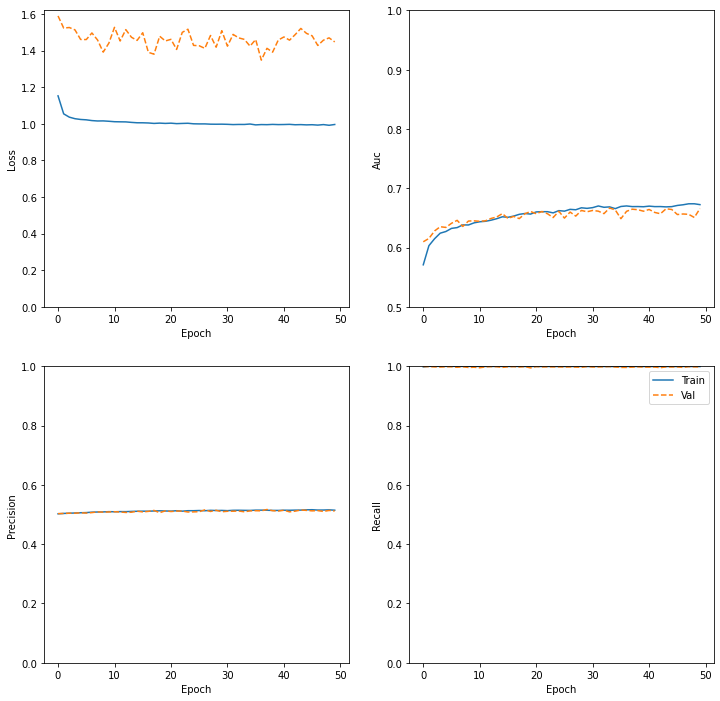

In [21]:
plot_metrics(weighted_history)

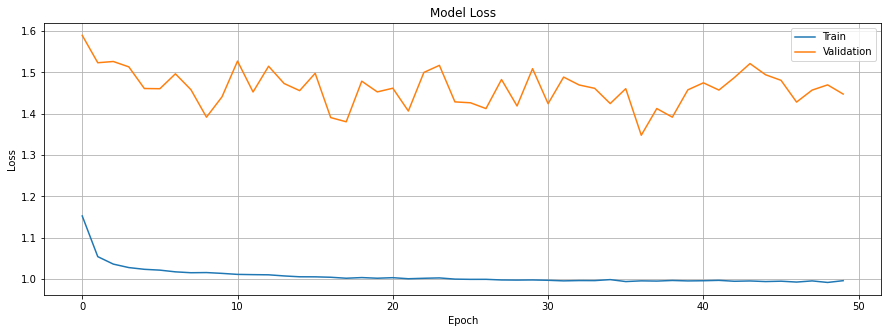

In [22]:
plt.figure(figsize=(15, 5))


plt.plot(weighted_history.history['loss'])
plt.plot(weighted_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

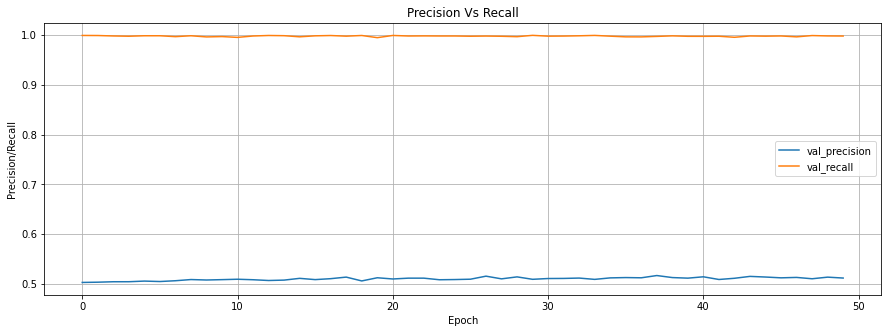

In [23]:
plt.figure(figsize=(15, 5))

plt.plot(weighted_history.history['val_precision'])
plt.plot(weighted_history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [25]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
weighted_train_accuracy = weighted_history.history["accuracy"][-1]
weighted_result = weighted_model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {weighted_train_accuracy:.4f}")
print(f"Test Accuracy: {weighted_result[5]:.4f}")
print(f"Test Precision: {weighted_result[6]:.4f}")
print(f"Test Recall: {weighted_result[7]:.4f}")
print(f"Test AUC: {weighted_result[8]:.4f}")
print(f"Test TP: {weighted_result[1]:.0f}")
print(f"Test FP: {weighted_result[2]:.0f}")
print(f"Test TN: {weighted_result[3]:.0f}")
print(f"Test FN: {weighted_result[4]:.0f}")

predictions = weighted_model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.5284
Test Accuracy: 0.0931
Test Precision: 0.0472
Test Recall: 0.9943
Test AUC: 0.6567
Test TP: 865
Test FP: 17458
Test TN: 928
Test FN: 5


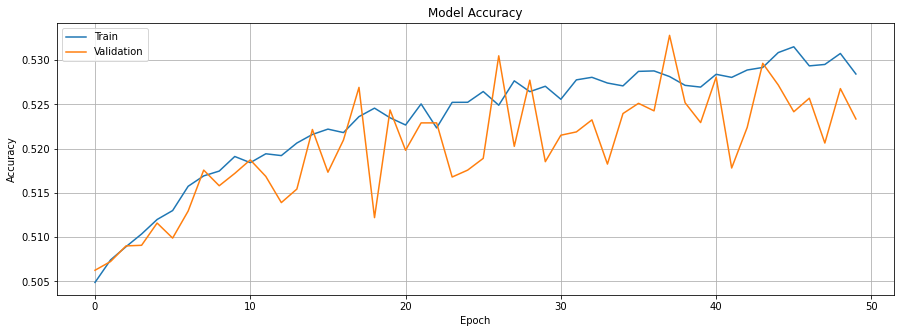

In [26]:
plt.figure(figsize=(15, 5))

plt.plot(weighted_history.history["accuracy"])
plt.plot(weighted_history.history["val_accuracy"])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [27]:
weighted_train_predictions_baseline = weighted_model.predict(X_train_os_ss_PCA10)
weighted_test_predictions_baseline = weighted_model.predict(X_test_ss_PCA10)

In [30]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  2.6787843704223633
tp :  865.0
fp :  17458.0
tn :  928.0
fn :  5.0
accuracy :  0.09311383217573166
precision :  0.047208428382873535
recall :  0.9942528605461121
auc :  0.6567457914352417

Non-Seizure Epochs Detected (True Negatives):  928
Non-Seizure Epochs Incorrectly Detected (False Positives):  17458
Pre-Seizure Epochs Missed (False Negatives):  5
Pre-Seizure Epochs Detected (True Positives):  865
Total Pre-Seizure Epochs:  870


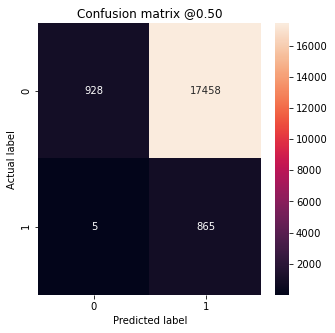

In [31]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

weighted_baseline_results = weighted_model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, weighted_test_predictions_baseline)

Extremely low accuracy on this model. the model performance is not better than that done using the same approach for detection problem.


-------------------------------

Now let us change the Dense network structure.

Model pre-3

In [35]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

epochs = 220

In [61]:
# Fit the model
# Cell 24

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))


peep_me()

Epoch 1/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.6345 - tp: 44425.0000 - fp: 26179.0000 - tn: 32656.0000 - fn: 14410.0000 - accuracy: 0.6551 - precision: 0.6292 - recall: 0.7551 - auc: 0.7182 - val_loss: 0.6459 - val_tp: 12366.0000 - val_fp: 7848.0000 - val_tn: 6861.0000 - val_fn: 2343.0000 - val_accuracy: 0.6536 - val_precision: 0.6118 - val_recall: 0.8407 - val_auc: 0.7141
Epoch 2/100
3678/3678 [==============================] - 13s 4ms/step - loss: 0.6336 - tp: 44105.0000 - fp: 25923.0000 - tn: 32912.0000 - fn: 14730.0000 - accuracy: 0.6545 - precision: 0.6298 - recall: 0.7496 - auc: 0.7190 - val_loss: 0.6618 - val_tp: 8810.0000 - val_fp: 5178.0000 - val_tn: 9531.0000 - val_fn: 5899.0000 - val_accuracy: 0.6235 - val_precision: 0.6298 - val_recall: 0.5990 - val_auc: 0.6902
Epoch 3/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.6350 - tp: 44314.0000 - fp: 26147.0000 - tn: 32688.0000 - fn: 14521.0000 - accuracy: 0.6544 - precision

3678/3678 [==============================] - 13s 3ms/step - loss: 0.6344 - tp: 44484.0000 - fp: 26305.0000 - tn: 32530.0000 - fn: 14351.0000 - accuracy: 0.6545 - precision: 0.6284 - recall: 0.7561 - auc: 0.7180 - val_loss: 0.6486 - val_tp: 12547.0000 - val_fp: 8210.0000 - val_tn: 6499.0000 - val_fn: 2162.0000 - val_accuracy: 0.6474 - val_precision: 0.6045 - val_recall: 0.8530 - val_auc: 0.7085
Epoch 41/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.6361 - tp: 44269.0000 - fp: 26170.0000 - tn: 32665.0000 - fn: 14566.0000 - accuracy: 0.6538 - precision: 0.6285 - recall: 0.7524 - auc: 0.7171 - val_loss: 0.6513 - val_tp: 11276.0000 - val_fp: 7101.0000 - val_tn: 7608.0000 - val_fn: 3433.0000 - val_accuracy: 0.6419 - val_precision: 0.6136 - val_recall: 0.7666 - val_auc: 0.6986
Epoch 42/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.6333 - tp: 44682.0000 - fp: 26381.0000 - tn: 32454.0000 - fn: 14153.0000 - accuracy: 0.6555 - precision: 0.6288 

3678/3678 [==============================] - 8s 2ms/step - loss: 0.6336 - tp: 44453.0000 - fp: 26004.0000 - tn: 32831.0000 - fn: 14382.0000 - accuracy: 0.6568 - precision: 0.6309 - recall: 0.7556 - auc: 0.7205 - val_loss: 0.6490 - val_tp: 11233.0000 - val_fp: 7177.0000 - val_tn: 7532.0000 - val_fn: 3476.0000 - val_accuracy: 0.6379 - val_precision: 0.6102 - val_recall: 0.7637 - val_auc: 0.6948
Epoch 81/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6334 - tp: 44365.0000 - fp: 25890.0000 - tn: 32945.0000 - fn: 14470.0000 - accuracy: 0.6570 - precision: 0.6315 - recall: 0.7541 - auc: 0.7218 - val_loss: 0.6597 - val_tp: 12530.0000 - val_fp: 8332.0000 - val_tn: 6377.0000 - val_fn: 2179.0000 - val_accuracy: 0.6427 - val_precision: 0.6006 - val_recall: 0.8519 - val_auc: 0.7002
Epoch 82/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6326 - tp: 44632.0000 - fp: 25988.0000 - tn: 32847.0000 - fn: 14203.0000 - accuracy: 0.6584 - precision: 0.6320 - r

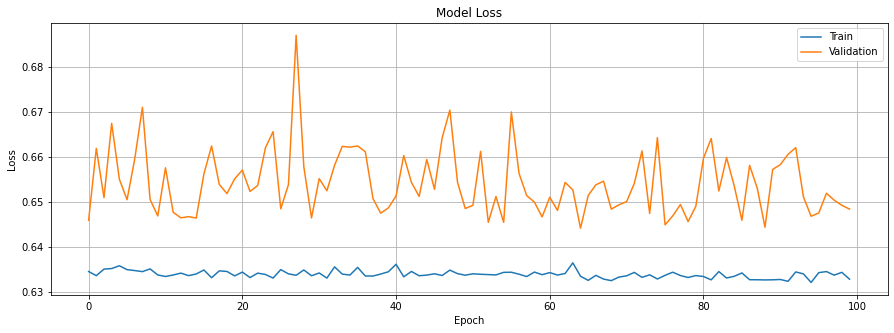

In [62]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

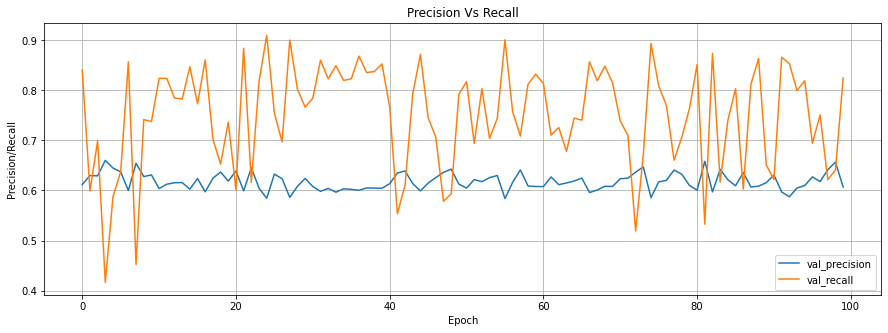

In [63]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [64]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.6599
Test Accuracy: 0.4876
Test Precision: 0.0657
Test Recall: 0.7816
Test AUC: 0.6882
Test TP: 680
Test FP: 9676
Test TN: 8710
Test FN: 190


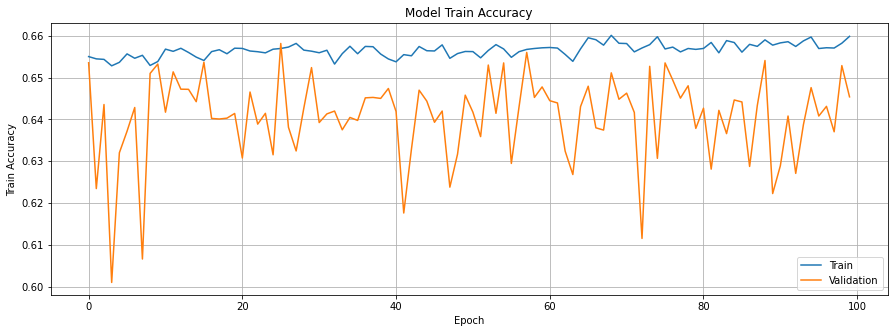

In [65]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [66]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [69]:
def plot_cm(labels, predictions, p=0.55):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.6886687278747559
tp :  680.0
fp :  9676.0
tn :  8710.0
fn :  190.0
accuracy :  0.4876402020454407
precision :  0.06566242128610611
recall :  0.7816091775894165
auc :  0.6881976127624512

Non-Seizure Epochs Detected (True Negatives):  10316
Non-Seizure Epochs Incorrectly Detected (False Positives):  8070
Pre-Seizure Epochs Missed (False Negatives):  255
Pre-Seizure Epochs Detected (True Positives):  615
Total Pre-Seizure Epochs:  870


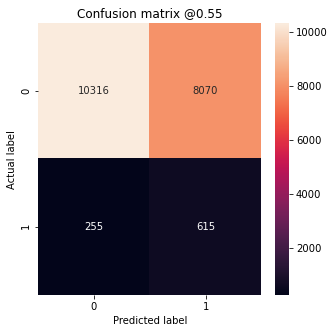

In [70]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The model structure was set to 5 layers instead of 3, the model was run for 220 epochs, at some points all metrics saturates and the final result is low accuracy at 0.48 and low precision at 0.66.  Also, the model throws high false positives.

-------------------------

Here we use the previous model but with no drop-out layers included.

Model pre-4

In [26]:
Model pre-1# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer)) 

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [27]:
# Fit the model
# Cell 25

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=150, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))


peep_me()

Epoch 1/150
3678/3678 [==============================] - 8s 2ms/step - loss: 0.7165 - tp: 43066.0000 - fp: 32820.0000 - tn: 26015.0000 - fn: 15769.0000 - accuracy: 0.5871 - precision: 0.5675 - recall: 0.7320 - auc: 0.6199 - val_loss: 0.6813 - val_tp: 10637.0000 - val_fp: 7900.0000 - val_tn: 6809.0000 - val_fn: 4072.0000 - val_accuracy: 0.5930 - val_precision: 0.5738 - val_recall: 0.7232 - val_auc: 0.6363
Epoch 2/150
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6671 - tp: 43644.0000 - fp: 31956.0000 - tn: 26879.0000 - fn: 15191.0000 - accuracy: 0.5993 - precision: 0.5773 - recall: 0.7418 - auc: 0.6420 - val_loss: 0.6724 - val_tp: 12719.0000 - val_fp: 9990.0000 - val_tn: 4719.0000 - val_fn: 1990.0000 - val_accuracy: 0.5928 - val_precision: 0.5601 - val_recall: 0.8647 - val_auc: 0.6397
Epoch 3/150
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6584 - tp: 43447.0000 - fp: 31172.0000 - tn: 27663.0000 - fn: 15388.0000 - accuracy: 0.6043 - precision: 

3678/3678 [==============================] - 8s 2ms/step - loss: 0.6002 - tp: 45704.0000 - fp: 23748.0000 - tn: 35087.0000 - fn: 13131.0000 - accuracy: 0.6866 - precision: 0.6581 - recall: 0.7768 - auc: 0.7589 - val_loss: 0.6680 - val_tp: 11907.0000 - val_fp: 7582.0000 - val_tn: 7127.0000 - val_fn: 2802.0000 - val_accuracy: 0.6470 - val_precision: 0.6110 - val_recall: 0.8095 - val_auc: 0.7047
Epoch 42/150
3678/3678 [==============================] - 8s 2ms/step - loss: 0.5999 - tp: 45747.0000 - fp: 23641.0000 - tn: 35194.0000 - fn: 13088.0000 - accuracy: 0.6879 - precision: 0.6593 - recall: 0.7775 - auc: 0.7600 - val_loss: 0.7197 - val_tp: 6656.0000 - val_fp: 3637.0000 - val_tn: 11072.0000 - val_fn: 8053.0000 - val_accuracy: 0.6026 - val_precision: 0.6467 - val_recall: 0.4525 - val_auc: 0.6876
Epoch 43/150
3678/3678 [==============================] - 9s 2ms/step - loss: 0.5988 - tp: 45767.0000 - fp: 23660.0000 - tn: 35175.0000 - fn: 13068.0000 - accuracy: 0.6879 - precision: 0.6592 - r

3678/3678 [==============================] - 8s 2ms/step - loss: 0.5907 - tp: 46512.0000 - fp: 23073.0000 - tn: 35762.0000 - fn: 12323.0000 - accuracy: 0.6992 - precision: 0.6684 - recall: 0.7905 - auc: 0.7724 - val_loss: 0.6784 - val_tp: 10950.0000 - val_fp: 6347.0000 - val_tn: 8362.0000 - val_fn: 3759.0000 - val_accuracy: 0.6565 - val_precision: 0.6331 - val_recall: 0.7444 - val_auc: 0.7076
Epoch 82/150
3678/3678 [==============================] - 8s 2ms/step - loss: 0.5909 - tp: 46390.0000 - fp: 22911.0000 - tn: 35924.0000 - fn: 12445.0000 - accuracy: 0.6995 - precision: 0.6694 - recall: 0.7885 - auc: 0.7732 - val_loss: 0.6954 - val_tp: 11349.0000 - val_fp: 7210.0000 - val_tn: 7499.0000 - val_fn: 3360.0000 - val_accuracy: 0.6407 - val_precision: 0.6115 - val_recall: 0.7716 - val_auc: 0.6914
Epoch 83/150
3678/3678 [==============================] - 8s 2ms/step - loss: 0.5898 - tp: 46653.0000 - fp: 23031.0000 - tn: 35804.0000 - fn: 12182.0000 - accuracy: 0.7007 - precision: 0.6695 - r

3678/3678 [==============================] - 8s 2ms/step - loss: 0.5860 - tp: 46736.0000 - fp: 22382.0000 - tn: 36453.0000 - fn: 12099.0000 - accuracy: 0.7070 - precision: 0.6762 - recall: 0.7944 - auc: 0.7804 - val_loss: 0.6875 - val_tp: 8698.0000 - val_fp: 4743.0000 - val_tn: 9966.0000 - val_fn: 6011.0000 - val_accuracy: 0.6344 - val_precision: 0.6471 - val_recall: 0.5913 - val_auc: 0.7059
Epoch 122/150
3678/3678 [==============================] - 8s 2ms/step - loss: 0.5854 - tp: 46814.0000 - fp: 22470.0000 - tn: 36365.0000 - fn: 12021.0000 - accuracy: 0.7069 - precision: 0.6757 - recall: 0.7957 - auc: 0.7804 - val_loss: 0.6778 - val_tp: 10557.0000 - val_fp: 5871.0000 - val_tn: 8838.0000 - val_fn: 4152.0000 - val_accuracy: 0.6593 - val_precision: 0.6426 - val_recall: 0.7177 - val_auc: 0.7112
Epoch 123/150
3678/3678 [==============================] - 8s 2ms/step - loss: 0.5851 - tp: 46762.0000 - fp: 22531.0000 - tn: 36304.0000 - fn: 12073.0000 - accuracy: 0.7059 - precision: 0.6748 - 

3678/3678 [==============================] - 9s 2ms/step - loss: 0.5818 - tp: 47244.0000 - fp: 22411.0000 - tn: 36424.0000 - fn: 11591.0000 - accuracy: 0.7110 - precision: 0.6783 - recall: 0.8030 - auc: 0.7850 - val_loss: 0.6997 - val_tp: 9673.0000 - val_fp: 5165.0000 - val_tn: 9544.0000 - val_fn: 5036.0000 - val_accuracy: 0.6532 - val_precision: 0.6519 - val_recall: 0.6576 - val_auc: 0.7155
Epoch 142/150
3678/3678 [==============================] - 9s 2ms/step - loss: 0.5812 - tp: 47130.0000 - fp: 22347.0000 - tn: 36488.0000 - fn: 11705.0000 - accuracy: 0.7106 - precision: 0.6784 - recall: 0.8011 - auc: 0.7861 - val_loss: 0.7049 - val_tp: 8837.0000 - val_fp: 4993.0000 - val_tn: 9716.0000 - val_fn: 5872.0000 - val_accuracy: 0.6307 - val_precision: 0.6390 - val_recall: 0.6008 - val_auc: 0.6974
Epoch 143/150
3678/3678 [==============================] - 9s 2ms/step - loss: 0.5817 - tp: 47179.0000 - fp: 22386.0000 - tn: 36449.0000 - fn: 11656.0000 - accuracy: 0.7107 - precision: 0.6782 - r

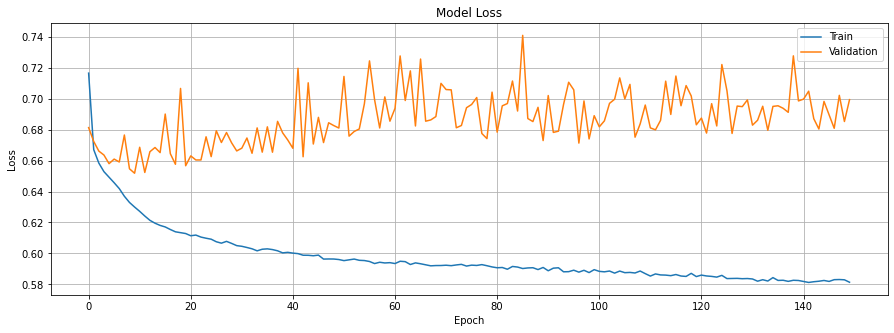

In [29]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

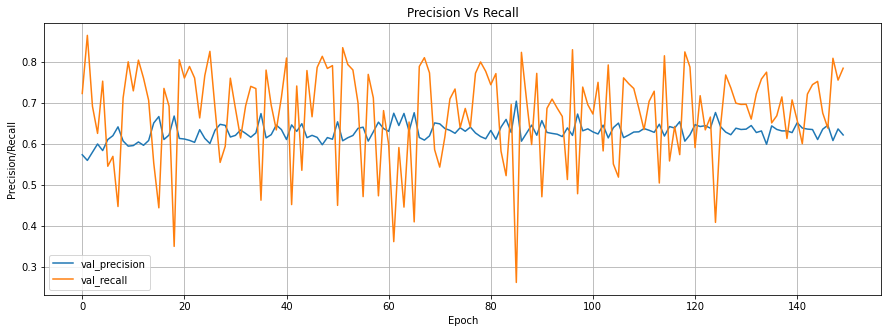

In [30]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [31]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.7107
Test Accuracy: 0.5434
Test Precision: 0.0694
Test Recall: 0.7333
Test AUC: 0.6922
Test TP: 638
Test FP: 8561
Test TN: 9825
Test FN: 232


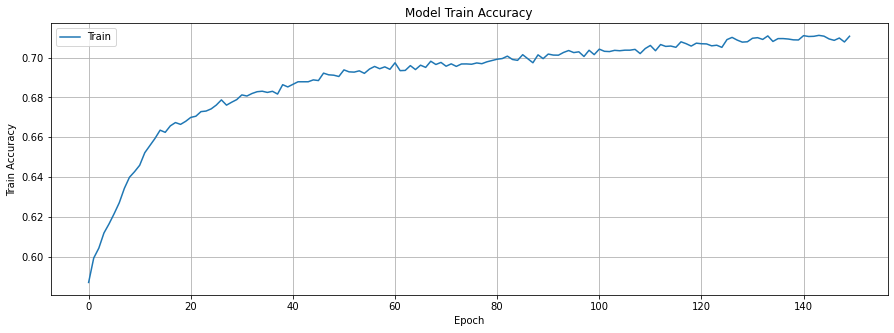

In [32]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [33]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [34]:
def plot_cm(labels, predictions, p=0.47):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.6976979970932007
tp :  638.0
fp :  8561.0
tn :  9825.0
fn :  232.0
accuracy :  0.543363094329834
precision :  0.06935536116361618
recall :  0.7333333492279053
auc :  0.6921511888504028

Non-Seizure Epochs Detected (True Negatives):  9326
Non-Seizure Epochs Incorrectly Detected (False Positives):  9060
Pre-Seizure Epochs Missed (False Negatives):  217
Pre-Seizure Epochs Detected (True Positives):  653
Total Pre-Seizure Epochs:  870


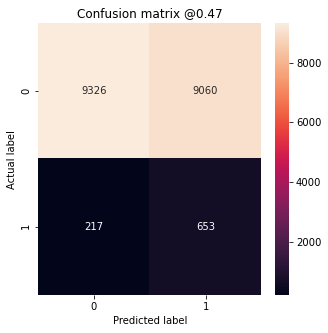

In [35]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

Results have no significant improvement compared to the previous model.

---------------------------------------------------

Also, the minmax scaler was used to scale the data before fitting few models - the code of which has been omitted -, the result however was not better than those obtained by using the standard scaler.  high mix on the observations was observed although the model was trained for for 100 epochs.

------------------------------

Now let us try the Hyperbolic Tangent (Tanh) activation function instead of Relu.

Model pre-6

In [32]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="tanh", kernel_regularizer=regularizer))

model.add(layers.Dense(40, activation="tanh", kernel_regularizer=regularizer))

model.add(layers.Dense(80, activation="tanh", kernel_regularizer=regularizer)) 

model.add(layers.Dense(80, activation="tanh", kernel_regularizer=regularizer))

model.add(layers.Dense(40, activation="tanh", kernel_regularizer=regularizer))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [33]:
# Fit the model
# Cell 27

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.7182 - tp: 41641.0000 - fp: 31928.0000 - tn: 26907.0000 - fn: 17194.0000 - accuracy: 0.5825 - precision: 0.5660 - recall: 0.7078 - auc: 0.6108 - val_loss: 0.6763 - val_tp: 12305.0000 - val_fp: 9501.0000 - val_tn: 5208.0000 - val_fn: 2404.0000 - val_accuracy: 0.5953 - val_precision: 0.5643 - val_recall: 0.8366 - val_auc: 0.6184
Epoch 2/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6685 - tp: 41916.0000 - fp: 31116.0000 - tn: 27719.0000 - fn: 16919.0000 - accuracy: 0.5918 - precision: 0.5739 - recall: 0.7124 - auc: 0.6276 - val_loss: 0.6696 - val_tp: 11482.0000 - val_fp: 8784.0000 - val_tn: 5925.0000 - val_fn: 3227.0000 - val_accuracy: 0.5917 - val_precision: 0.5666 - val_recall: 0.7806 - val_auc: 0.6282
Epoch 3/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6626 - tp: 41806.0000 - fp: 30571.0000 - tn: 28264.0000 - fn: 17029.0000 - accuracy: 0.5955 - precision: 

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6454 - tp: 42784.0000 - fp: 28841.0000 - tn: 29994.0000 - fn: 16051.0000 - accuracy: 0.6185 - precision: 0.5973 - recall: 0.7272 - auc: 0.6741 - val_loss: 0.6693 - val_tp: 8740.0000 - val_fp: 5721.0000 - val_tn: 8988.0000 - val_fn: 5969.0000 - val_accuracy: 0.6026 - val_precision: 0.6044 - val_recall: 0.5942 - val_auc: 0.6512
Epoch 22/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6453 - tp: 42521.0000 - fp: 28761.0000 - tn: 30074.0000 - fn: 16314.0000 - accuracy: 0.6169 - precision: 0.5965 - recall: 0.7227 - auc: 0.6742 - val_loss: 0.6664 - val_tp: 12555.0000 - val_fp: 9372.0000 - val_tn: 5337.0000 - val_fn: 2154.0000 - val_accuracy: 0.6082 - val_precision: 0.5726 - val_recall: 0.8536 - val_auc: 0.6540
Epoch 23/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6454 - tp: 42543.0000 - fp: 28693.0000 - tn: 30142.0000 - fn: 16292.0000 - accuracy: 0.6177 - precision: 0.5972 - re

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6422 - tp: 42675.0000 - fp: 28319.0000 - tn: 30516.0000 - fn: 16160.0000 - accuracy: 0.6220 - precision: 0.6011 - recall: 0.7253 - auc: 0.6808 - val_loss: 0.6632 - val_tp: 11387.0000 - val_fp: 8164.0000 - val_tn: 6545.0000 - val_fn: 3322.0000 - val_accuracy: 0.6096 - val_precision: 0.5824 - val_recall: 0.7742 - val_auc: 0.6535
Epoch 42/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6424 - tp: 42747.0000 - fp: 28427.0000 - tn: 30408.0000 - fn: 16088.0000 - accuracy: 0.6217 - precision: 0.6006 - recall: 0.7266 - auc: 0.6806 - val_loss: 0.6715 - val_tp: 9166.0000 - val_fp: 6097.0000 - val_tn: 8612.0000 - val_fn: 5543.0000 - val_accuracy: 0.6043 - val_precision: 0.6005 - val_recall: 0.6232 - val_auc: 0.6469
Epoch 43/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6423 - tp: 42761.0000 - fp: 28504.0000 - tn: 30331.0000 - fn: 16074.0000 - accuracy: 0.6212 - precision: 0.6000 - re

3678/3678 [==============================] - 6s 2ms/step - loss: 0.6406 - tp: 43045.0000 - fp: 28432.0000 - tn: 30403.0000 - fn: 15790.0000 - accuracy: 0.6242 - precision: 0.6022 - recall: 0.7316 - auc: 0.6848 - val_loss: 0.6619 - val_tp: 11295.0000 - val_fp: 7941.0000 - val_tn: 6768.0000 - val_fn: 3414.0000 - val_accuracy: 0.6140 - val_precision: 0.5872 - val_recall: 0.7679 - val_auc: 0.6583
Epoch 62/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6407 - tp: 43085.0000 - fp: 28561.0000 - tn: 30274.0000 - fn: 15750.0000 - accuracy: 0.6234 - precision: 0.6014 - recall: 0.7323 - auc: 0.6837 - val_loss: 0.6640 - val_tp: 10828.0000 - val_fp: 7640.0000 - val_tn: 7069.0000 - val_fn: 3881.0000 - val_accuracy: 0.6084 - val_precision: 0.5863 - val_recall: 0.7361 - val_auc: 0.6565
Epoch 63/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6407 - tp: 43259.0000 - fp: 28699.0000 - tn: 30136.0000 - fn: 15576.0000 - accuracy: 0.6237 - precision: 0.6012 - r

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6398 - tp: 43267.0000 - fp: 28382.0000 - tn: 30453.0000 - fn: 15568.0000 - accuracy: 0.6265 - precision: 0.6039 - recall: 0.7354 - auc: 0.6865 - val_loss: 0.6654 - val_tp: 10645.0000 - val_fp: 7726.0000 - val_tn: 6983.0000 - val_fn: 4064.0000 - val_accuracy: 0.5992 - val_precision: 0.5794 - val_recall: 0.7237 - val_auc: 0.6548
Epoch 82/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6400 - tp: 43334.0000 - fp: 28357.0000 - tn: 30478.0000 - fn: 15501.0000 - accuracy: 0.6273 - precision: 0.6045 - recall: 0.7365 - auc: 0.6862 - val_loss: 0.6673 - val_tp: 9207.0000 - val_fp: 6159.0000 - val_tn: 8550.0000 - val_fn: 5502.0000 - val_accuracy: 0.6036 - val_precision: 0.5992 - val_recall: 0.6259 - val_auc: 0.6561
Epoch 83/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6394 - tp: 43415.0000 - fp: 28445.0000 - tn: 30390.0000 - fn: 15420.0000 - accuracy: 0.6272 - precision: 0.6042 - re

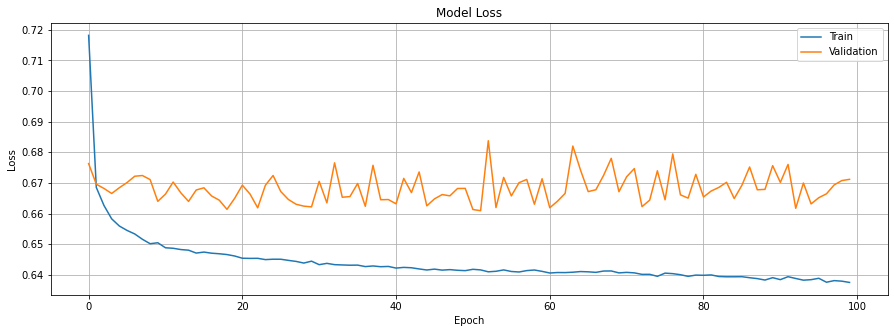

In [34]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

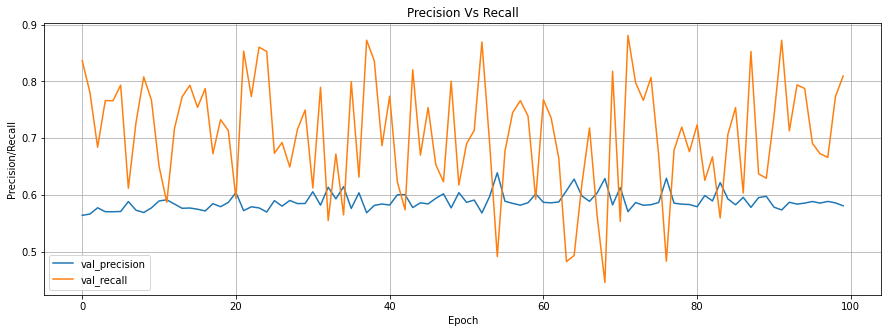

In [35]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

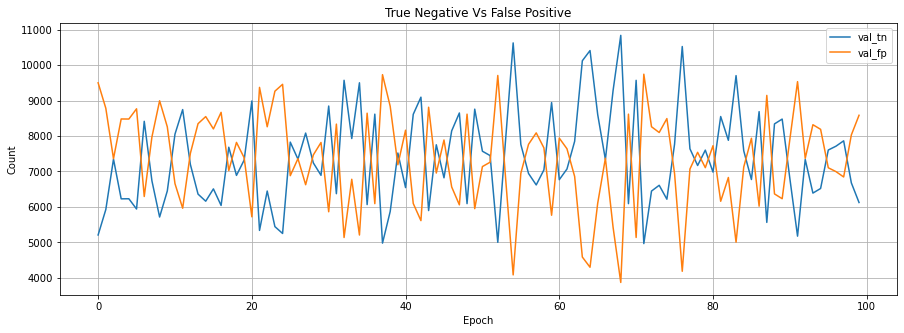

In [36]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [37]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.6273
Test Accuracy: 0.4363
Test Precision: 0.0591
Test Recall: 0.7690
Test AUC: 0.6401
Test TP: 669
Test FP: 10654
Test TN: 7732
Test FN: 201


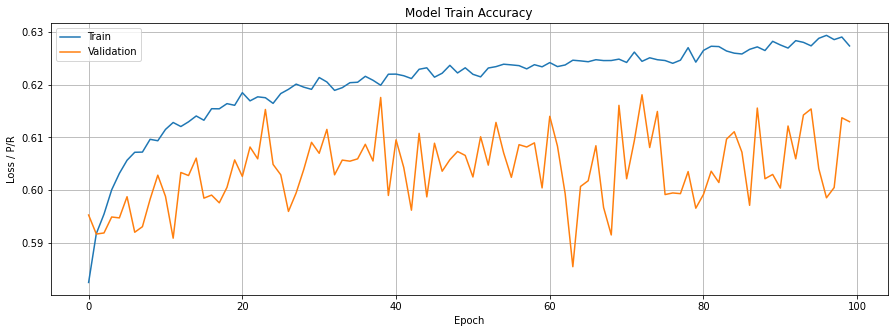

In [42]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Loss / P/R')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [39]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [43]:
def plot_cm(labels, predictions, p=0.55):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.7151422500610352
tp :  669.0
fp :  10654.0
tn :  7732.0
fn :  201.0
accuracy :  0.4362795948982239
precision :  0.05908328294754028
recall :  0.7689655423164368
auc :  0.6400798559188843

Non-Seizure Epochs Detected (True Negatives):  9724
Non-Seizure Epochs Incorrectly Detected (False Positives):  8662
Pre-Seizure Epochs Missed (False Negatives):  293
Pre-Seizure Epochs Detected (True Positives):  577
Total Pre-Seizure Epochs:  870


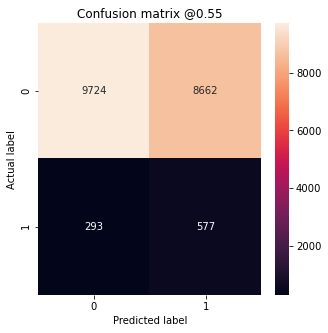

In [44]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

Tried 100 epochs with Tanh activation until the model val accuracy saturates. the resulting accuracy at ~0.4 is the worst one so far.

--------------------------------------------------

Now let us try the SELU activation function instead of Relu with cell 25

Model pre-7

In [45]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

epochs=100

In [46]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.8256 - tp: 39708.0000 - fp: 29955.0000 - tn: 28880.0000 - fn: 19127.0000 - accuracy: 0.5829 - precision: 0.5700 - recall: 0.6749 - auc: 0.6188 - val_loss: 0.7278 - val_tp: 4309.0000 - val_fp: 3063.0000 - val_tn: 11646.0000 - val_fn: 10400.0000 - val_accuracy: 0.5424 - val_precision: 0.5845 - val_recall: 0.2929 - val_auc: 0.6266
Epoch 2/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6911 - tp: 42685.0000 - fp: 32204.0000 - tn: 26631.0000 - fn: 16150.0000 - accuracy: 0.5891 - precision: 0.5700 - recall: 0.7255 - auc: 0.6253 - val_loss: 0.6803 - val_tp: 11173.0000 - val_fp: 8458.0000 - val_tn: 6251.0000 - val_fn: 3536.0000 - val_accuracy: 0.5923 - val_precision: 0.5692 - val_recall: 0.7596 - val_auc: 0.6157
Epoch 3/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6696 - tp: 43580.0000 - fp: 32517.0000 - tn: 26318.0000 - fn: 15255.0000 - accuracy: 0.5940 - precision:

3678/3678 [==============================] - 8s 2ms/step - loss: 0.6498 - tp: 43237.0000 - fp: 30199.0000 - tn: 28636.0000 - fn: 15598.0000 - accuracy: 0.6108 - precision: 0.5888 - recall: 0.7349 - auc: 0.6637 - val_loss: 0.6656 - val_tp: 11239.0000 - val_fp: 8199.0000 - val_tn: 6510.0000 - val_fn: 3470.0000 - val_accuracy: 0.6033 - val_precision: 0.5782 - val_recall: 0.7641 - val_auc: 0.6456
Epoch 22/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6488 - tp: 43327.0000 - fp: 30193.0000 - tn: 28642.0000 - fn: 15508.0000 - accuracy: 0.6116 - precision: 0.5893 - recall: 0.7364 - auc: 0.6650 - val_loss: 0.6673 - val_tp: 10793.0000 - val_fp: 7882.0000 - val_tn: 6827.0000 - val_fn: 3916.0000 - val_accuracy: 0.5990 - val_precision: 0.5779 - val_recall: 0.7338 - val_auc: 0.6442
Epoch 23/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6484 - tp: 43326.0000 - fp: 30048.0000 - tn: 28787.0000 - fn: 15509.0000 - accuracy: 0.6128 - precision: 0.5905 - r

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6428 - tp: 42938.0000 - fp: 28653.0000 - tn: 30182.0000 - fn: 15897.0000 - accuracy: 0.6214 - precision: 0.5998 - recall: 0.7298 - auc: 0.6806 - val_loss: 0.6671 - val_tp: 10748.0000 - val_fp: 7539.0000 - val_tn: 7170.0000 - val_fn: 3961.0000 - val_accuracy: 0.6091 - val_precision: 0.5877 - val_recall: 0.7307 - val_auc: 0.6539
Epoch 42/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6423 - tp: 42940.0000 - fp: 28517.0000 - tn: 30318.0000 - fn: 15895.0000 - accuracy: 0.6226 - precision: 0.6009 - recall: 0.7298 - auc: 0.6817 - val_loss: 0.6770 - val_tp: 8622.0000 - val_fp: 5808.0000 - val_tn: 8901.0000 - val_fn: 6087.0000 - val_accuracy: 0.5957 - val_precision: 0.5975 - val_recall: 0.5862 - val_auc: 0.6472
Epoch 43/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6424 - tp: 42927.0000 - fp: 28690.0000 - tn: 30145.0000 - fn: 15908.0000 - accuracy: 0.6210 - precision: 0.5994 - re

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6402 - tp: 42480.0000 - fp: 27960.0000 - tn: 30875.0000 - fn: 16355.0000 - accuracy: 0.6234 - precision: 0.6031 - recall: 0.7220 - auc: 0.6863 - val_loss: 0.6736 - val_tp: 12412.0000 - val_fp: 9020.0000 - val_tn: 5689.0000 - val_fn: 2297.0000 - val_accuracy: 0.6153 - val_precision: 0.5791 - val_recall: 0.8438 - val_auc: 0.6583
Epoch 62/100
3678/3678 [==============================] - 7s 2ms/step - loss: 0.6401 - tp: 42624.0000 - fp: 27877.0000 - tn: 30958.0000 - fn: 16211.0000 - accuracy: 0.6253 - precision: 0.6046 - recall: 0.7245 - auc: 0.6871 - val_loss: 0.6756 - val_tp: 10566.0000 - val_fp: 7417.0000 - val_tn: 7292.0000 - val_fn: 4143.0000 - val_accuracy: 0.6070 - val_precision: 0.5876 - val_recall: 0.7183 - val_auc: 0.6540
Epoch 63/100
3678/3678 [==============================] - 6s 2ms/step - loss: 0.6397 - tp: 42614.0000 - fp: 27948.0000 - tn: 30887.0000 - fn: 16221.0000 - accuracy: 0.6246 - precision: 0.6039 - r

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6388 - tp: 42856.0000 - fp: 27833.0000 - tn: 31002.0000 - fn: 15979.0000 - accuracy: 0.6277 - precision: 0.6063 - recall: 0.7284 - auc: 0.6898 - val_loss: 0.6762 - val_tp: 11500.0000 - val_fp: 8212.0000 - val_tn: 6497.0000 - val_fn: 3209.0000 - val_accuracy: 0.6118 - val_precision: 0.5834 - val_recall: 0.7818 - val_auc: 0.6539
Epoch 82/100
3678/3678 [==============================] - 9s 2ms/step - loss: 0.6386 - tp: 42847.0000 - fp: 27814.0000 - tn: 31021.0000 - fn: 15988.0000 - accuracy: 0.6278 - precision: 0.6064 - recall: 0.7283 - auc: 0.6907 - val_loss: 0.6661 - val_tp: 11111.0000 - val_fp: 7697.0000 - val_tn: 7012.0000 - val_fn: 3598.0000 - val_accuracy: 0.6161 - val_precision: 0.5908 - val_recall: 0.7554 - val_auc: 0.6591
Epoch 83/100
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6378 - tp: 42718.0000 - fp: 27919.0000 - tn: 30916.0000 - fn: 16117.0000 - accuracy: 0.6258 - precision: 0.6048 - r

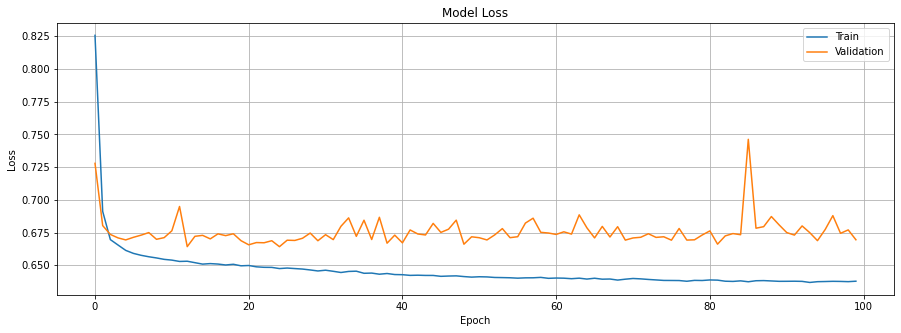

In [47]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

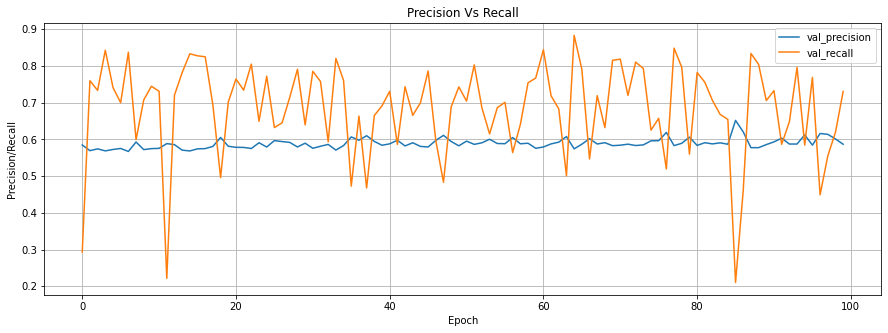

In [48]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

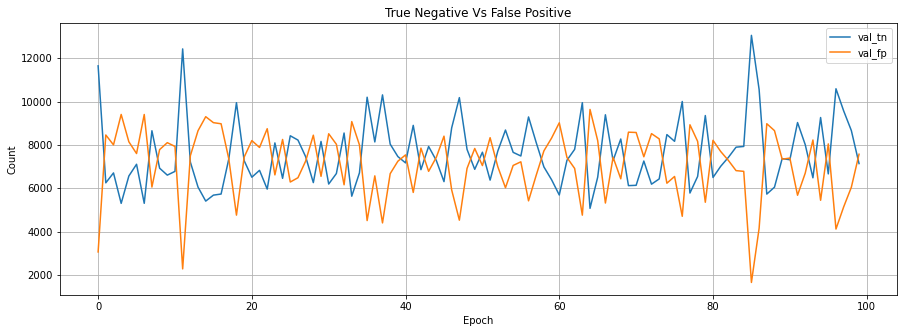

In [49]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [50]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.6297
Test Accuracy: 0.5025
Test Precision: 0.0638
Test Recall: 0.7322
Test AUC: 0.6587
Test TP: 637
Test FP: 9347
Test TN: 9039
Test FN: 233


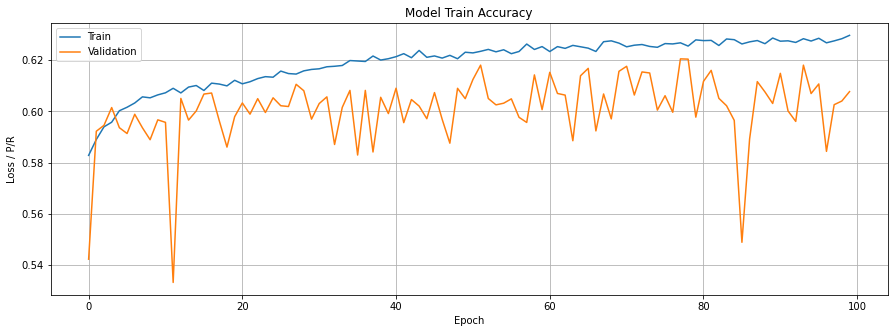

In [51]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Loss / P/R')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [52]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [72]:
def plot_cm(labels, predictions, p=0.47):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.6587172746658325
tp :  637.0
fp :  9347.0
tn :  9039.0
fn :  233.0
accuracy :  0.5024927258491516
precision :  0.0638020858168602
recall :  0.7321839332580566
auc :  0.6587191224098206

Non-Seizure Epochs Detected (True Negatives):  7707
Non-Seizure Epochs Incorrectly Detected (False Positives):  10679
Pre-Seizure Epochs Missed (False Negatives):  180
Pre-Seizure Epochs Detected (True Positives):  690
Total Pre-Seizure Epochs:  870


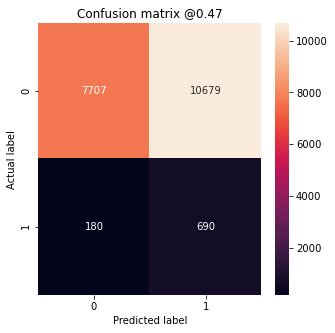

In [73]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

This model was run for 100 epochs with Selu activation. the resulting accuracy is low and so do the precision, but the recall is good. The model however throws high false positives. This model combination gave relatively good results on the detection po=roblem model optimization.

------------------------------------------------------

Let us change the Optimizer from relu to SGD optimizer.

Model pre-9

In [82]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.SGD(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [ ]:
epochs=50

In [83]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=50, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/50
3678/3678 [==============================] - 7s 2ms/step - loss: 0.9622 - tp: 39840.0000 - fp: 29276.0000 - tn: 29559.0000 - fn: 18995.0000 - accuracy: 0.5898 - precision: 0.5764 - recall: 0.6771 - auc: 0.6262 - val_loss: 0.9373 - val_tp: 10387.0000 - val_fp: 7533.0000 - val_tn: 7176.0000 - val_fn: 4322.0000 - val_accuracy: 0.5970 - val_precision: 0.5796 - val_recall: 0.7062 - val_auc: 0.6353
Epoch 2/50
3678/3678 [==============================] - 6s 2ms/step - loss: 0.9107 - tp: 40992.0000 - fp: 28851.0000 - tn: 29984.0000 - fn: 17843.0000 - accuracy: 0.6032 - precision: 0.5869 - recall: 0.6967 - auc: 0.6493 - val_loss: 0.9102 - val_tp: 8055.0000 - val_fp: 5545.0000 - val_tn: 9164.0000 - val_fn: 6654.0000 - val_accuracy: 0.5853 - val_precision: 0.5923 - val_recall: 0.5476 - val_auc: 0.6265
Epoch 3/50
3678/3678 [==============================] - 6s 2ms/step - loss: 0.8717 - tp: 41157.0000 - fp: 28420.0000 - tn: 30415.0000 - fn: 17678.0000 - accuracy: 0.6082 - precision: 0.59

3678/3678 [==============================] - 13s 3ms/step - loss: 0.6402 - tp: 44580.0000 - fp: 25220.0000 - tn: 33615.0000 - fn: 14255.0000 - accuracy: 0.6645 - precision: 0.6387 - recall: 0.7577 - auc: 0.7375 - val_loss: 0.8833 - val_tp: 1144.0000 - val_fp: 366.0000 - val_tn: 14343.0000 - val_fn: 13565.0000 - val_accuracy: 0.5264 - val_precision: 0.7576 - val_recall: 0.0778 - val_auc: 0.6719
Epoch 22/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6374 - tp: 44732.0000 - fp: 25136.0000 - tn: 33699.0000 - fn: 14103.0000 - accuracy: 0.6665 - precision: 0.6402 - recall: 0.7603 - auc: 0.7393 - val_loss: 0.7880 - val_tp: 4128.0000 - val_fp: 2218.0000 - val_tn: 12491.0000 - val_fn: 10581.0000 - val_accuracy: 0.5649 - val_precision: 0.6505 - val_recall: 0.2806 - val_auc: 0.6747
Epoch 23/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.6343 - tp: 44721.0000 - fp: 24991.0000 - tn: 33844.0000 - fn: 14114.0000 - accuracy: 0.6677 - precision: 0.6415 - r

3678/3678 [==============================] - 7s 2ms/step - loss: 0.6094 - tp: 45418.0000 - fp: 23132.0000 - tn: 35703.0000 - fn: 13417.0000 - accuracy: 0.6894 - precision: 0.6626 - recall: 0.7720 - auc: 0.7713 - val_loss: 0.7275 - val_tp: 11504.0000 - val_fp: 7749.0000 - val_tn: 6960.0000 - val_fn: 3205.0000 - val_accuracy: 0.6276 - val_precision: 0.5975 - val_recall: 0.7821 - val_auc: 0.6687
Epoch 42/50
3678/3678 [==============================] - 9s 3ms/step - loss: 0.6070 - tp: 45717.0000 - fp: 23012.0000 - tn: 35823.0000 - fn: 13118.0000 - accuracy: 0.6930 - precision: 0.6652 - recall: 0.7770 - auc: 0.7755 - val_loss: 0.7197 - val_tp: 8852.0000 - val_fp: 5441.0000 - val_tn: 9268.0000 - val_fn: 5857.0000 - val_accuracy: 0.6159 - val_precision: 0.6193 - val_recall: 0.6018 - val_auc: 0.6775
Epoch 43/50
3678/3678 [==============================] - 9s 2ms/step - loss: 0.6067 - tp: 45595.0000 - fp: 23086.0000 - tn: 35749.0000 - fn: 13240.0000 - accuracy: 0.6913 - precision: 0.6639 - reca

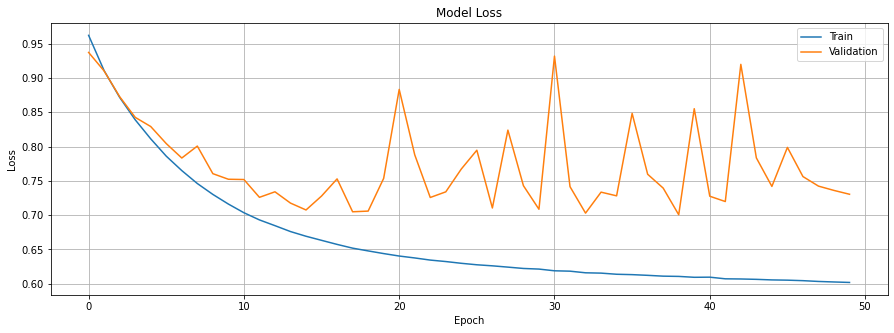

In [84]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

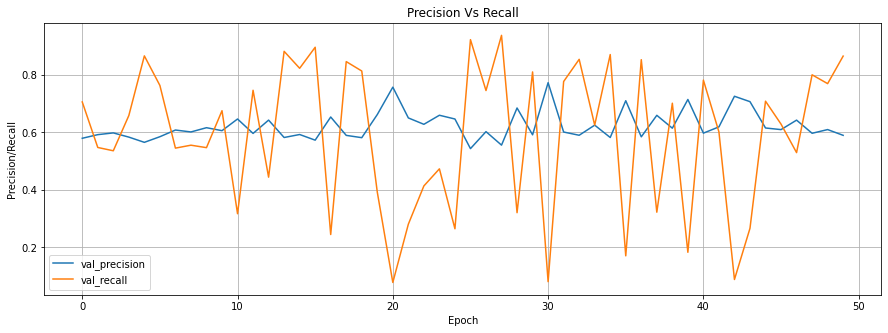

In [85]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

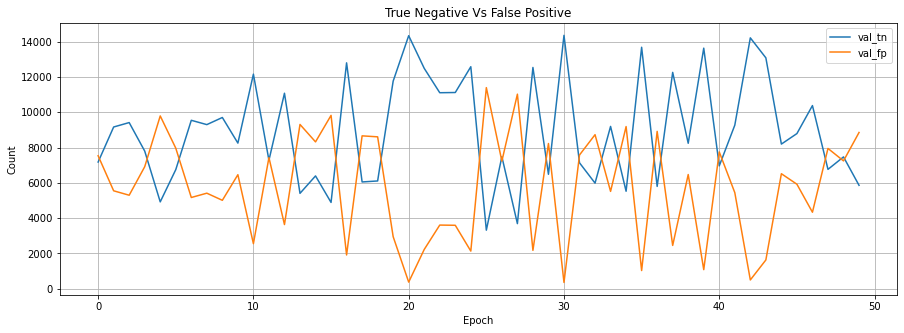

In [86]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [87]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.6994
Test Accuracy: 0.4212
Test Precision: 0.0609
Test Recall: 0.8195
Test AUC: 0.6768
Test TP: 713
Test FP: 10989
Test TN: 7397
Test FN: 157


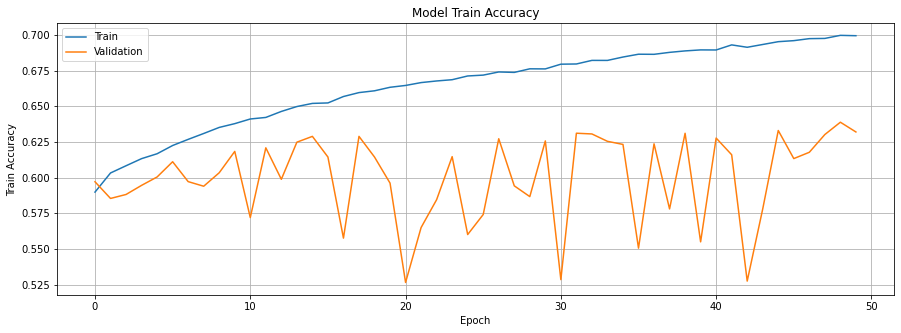

In [88]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [89]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [90]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.8965082168579102
tp :  713.0
fp :  10989.0
tn :  7397.0
fn :  157.0
accuracy :  0.42116743326187134
precision :  0.06092975661158562
recall :  0.8195402026176453
auc :  0.6768474578857422

Non-Seizure Epochs Detected (True Negatives):  7397
Non-Seizure Epochs Incorrectly Detected (False Positives):  10989
Pre-Seizure Epochs Missed (False Negatives):  157
Pre-Seizure Epochs Detected (True Positives):  713
Total Pre-Seizure Epochs:  870


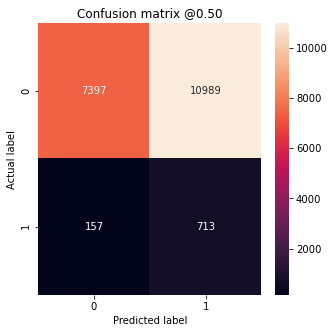

In [91]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

This model resulted in a relatively high recall but low accuracy and precision leading to high misclassification on the negative class. It was noticed that the validation metrics were very unstable during model fitting indicating a model of low performance.

-------------------------------------------------


To reduce the model instability see in the previous SGD model the model structure changes using the same optimizer by introducing two  20% drop-out layers.

Model pre-10

In [108]:
Model pre-1# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))
model.add(layers.Dropout(0.2)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))
model.add(layers.Dropout(0.2)) # Set 20% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001,),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [ ]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/100
3678/3678 [==============================] - 14s 4ms/step - loss: 0.8503 - tp: 30484.0000 - fp: 28349.0000 - tn: 30486.0000 - fn: 28351.0000 - accuracy: 0.5181 - precision: 0.5181 - recall: 0.5181 - auc: 0.5237 - val_loss: 0.7765 - val_tp: 12586.0000 - val_fp: 10602.0000 - val_tn: 4107.0000 - val_fn: 2123.0000 - val_accuracy: 0.5674 - val_precision: 0.5428 - val_recall: 0.8557 - val_auc: 0.5998
Epoch 2/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7970 - tp: 34571.0000 - fp: 30888.0000 - tn: 27947.0000 - fn: 24264.0000 - accuracy: 0.5313 - precision: 0.5281 - recall: 0.5876 - auc: 0.5464 - val_loss: 0.7744 - val_tp: 12648.0000 - val_fp: 10595.0000 - val_tn: 4114.0000 - val_fn: 2061.0000 - val_accuracy: 0.5698 - val_precision: 0.5442 - val_recall: 0.8599 - val_auc: 0.6024
Epoch 3/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.7879 - tp: 35975.0000 - fp: 31820.0000 - tn: 27015.0000 - fn: 22860.0000 - accuracy: 0.5353 - precis

Epoch 21/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7462 - tp: 42712.0000 - fp: 34151.0000 - tn: 24684.0000 - fn: 16123.0000 - accuracy: 0.5728 - precision: 0.5557 - recall: 0.7260 - auc: 0.5960 - val_loss: 0.7391 - val_tp: 12400.0000 - val_fp: 9770.0000 - val_tn: 4939.0000 - val_fn: 2309.0000 - val_accuracy: 0.5894 - val_precision: 0.5593 - val_recall: 0.8430 - val_auc: 0.6184
Epoch 22/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7449 - tp: 42727.0000 - fp: 34144.0000 - tn: 24691.0000 - fn: 16108.0000 - accuracy: 0.5729 - precision: 0.5558 - recall: 0.7262 - auc: 0.5951 - val_loss: 0.7377 - val_tp: 12294.0000 - val_fp: 9587.0000 - val_tn: 5122.0000 - val_fn: 2415.0000 - val_accuracy: 0.5920 - val_precision: 0.5619 - val_recall: 0.8358 - val_auc: 0.6202
Epoch 23/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7432 - tp: 42865.0000 - fp: 34106.0000 - tn: 24729.0000 - fn: 15970.0000 - accuracy: 0.5744 - preci

Epoch 41/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7221 - tp: 43085.0000 - fp: 33508.0000 - tn: 25327.0000 - fn: 15750.0000 - accuracy: 0.5814 - precision: 0.5625 - recall: 0.7323 - auc: 0.6103 - val_loss: 0.7173 - val_tp: 11390.0000 - val_fp: 8789.0000 - val_tn: 5920.0000 - val_fn: 3319.0000 - val_accuracy: 0.5884 - val_precision: 0.5644 - val_recall: 0.7744 - val_auc: 0.6239
Epoch 42/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7208 - tp: 43245.0000 - fp: 33433.0000 - tn: 25402.0000 - fn: 15590.0000 - accuracy: 0.5834 - precision: 0.5640 - recall: 0.7350 - auc: 0.6114 - val_loss: 0.7167 - val_tp: 11542.0000 - val_fp: 8956.0000 - val_tn: 5753.0000 - val_fn: 3167.0000 - val_accuracy: 0.5879 - val_precision: 0.5631 - val_recall: 0.7847 - val_auc: 0.6249
Epoch 43/100
3678/3678 [==============================] - 12s 3ms/step - loss: 0.7196 - tp: 43040.0000 - fp: 33237.0000 - tn: 25598.0000 - fn: 15795.0000 - accuracy: 0.5833 - preci

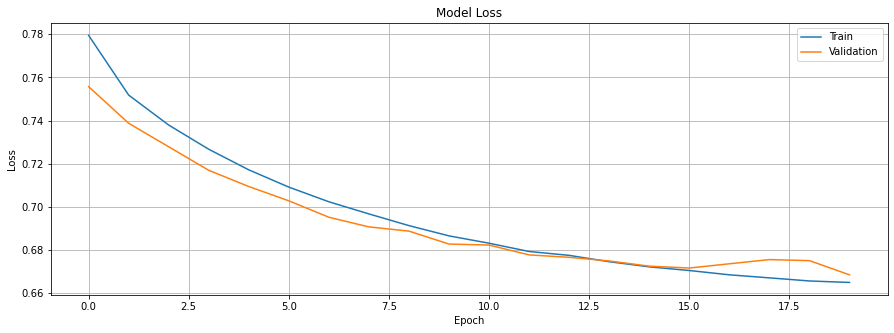

In [104]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

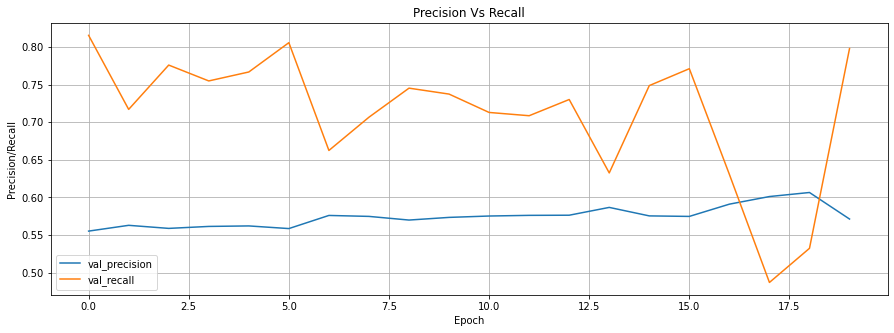

In [105]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

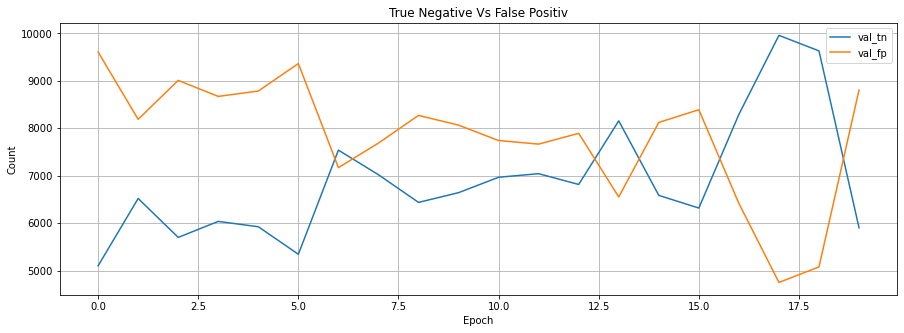

In [98]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [99]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")



predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.5998
Test Accuracy: 0.4214
Test Precision: 0.0579
Test Recall: 0.7724
Test AUC: 0.6356
Test TP: 672
Test FP: 10943
Test TN: 7443
Test FN: 198


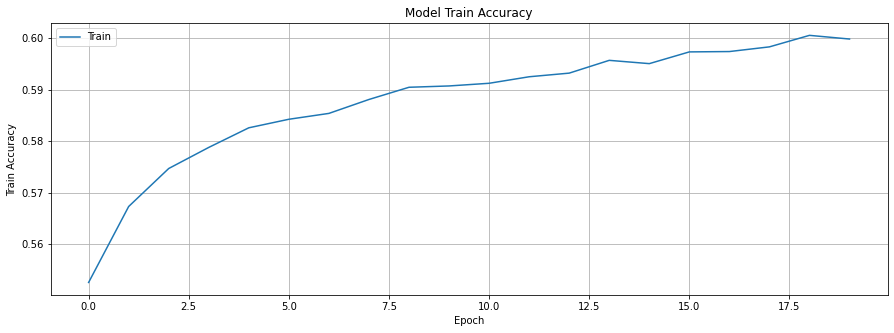

In [100]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [101]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [106]:
def plot_cm(labels, predictions, p=0.55):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.7144395112991333
tp :  672.0
fp :  10943.0
tn :  7443.0
fn :  198.0
accuracy :  0.4214271008968353
precision :  0.05785622075200081
recall :  0.7724137902259827
auc :  0.6356065273284912

Non-Seizure Epochs Detected (True Negatives):  10255
Non-Seizure Epochs Incorrectly Detected (False Positives):  8131
Pre-Seizure Epochs Missed (False Negatives):  335
Pre-Seizure Epochs Detected (True Positives):  535
Total Pre-Seizure Epochs:  870


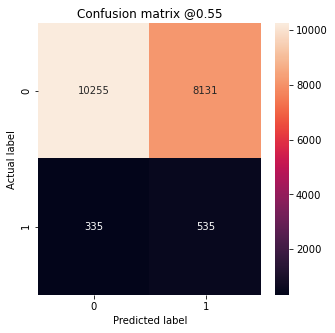

In [107]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

It was noticed that the train false positives were increasing from one epoch to another, this model is not considered.

----------------------------------------

Now try NADAM optimizer.

Model pre-11

In [93]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Nadam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [ ]:
epochs=140

In [103]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=120, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/120
3678/3678 [==============================] - 7s 2ms/step - loss: 0.5984 - tp: 45173.0000 - fp: 23338.0000 - tn: 35497.0000 - fn: 13662.0000 - accuracy: 0.6856 - precision: 0.6594 - recall: 0.7678 - auc: 0.7622 - val_loss: 0.6802 - val_tp: 8540.0000 - val_fp: 4774.0000 - val_tn: 9935.0000 - val_fn: 6169.0000 - val_accuracy: 0.6280 - val_precision: 0.6414 - val_recall: 0.5806 - val_auc: 0.6974
Epoch 2/120
3678/3678 [==============================] - 7s 2ms/step - loss: 0.5983 - tp: 44908.0000 - fp: 23056.0000 - tn: 35779.0000 - fn: 13927.0000 - accuracy: 0.6857 - precision: 0.6608 - recall: 0.7633 - auc: 0.7632 - val_loss: 0.6832 - val_tp: 7594.0000 - val_fp: 3677.0000 - val_tn: 11032.0000 - val_fn: 7115.0000 - val_accuracy: 0.6331 - val_precision: 0.6738 - val_recall: 0.5163 - val_auc: 0.7063
Epoch 3/120
3678/3678 [==============================] - 7s 2ms/step - loss: 0.5973 - tp: 45034.0000 - fp: 22875.0000 - tn: 35960.0000 - fn: 13801.0000 - accuracy: 0.6883 - precision: 0

3678/3678 [==============================] - 7s 2ms/step - loss: 0.5714 - tp: 46340.0000 - fp: 20395.0000 - tn: 38440.0000 - fn: 12495.0000 - accuracy: 0.7205 - precision: 0.6944 - recall: 0.7876 - auc: 0.8012 - val_loss: 0.6639 - val_tp: 11250.0000 - val_fp: 5867.0000 - val_tn: 8842.0000 - val_fn: 3459.0000 - val_accuracy: 0.6830 - val_precision: 0.6572 - val_recall: 0.7648 - val_auc: 0.7388
Epoch 42/120
3678/3678 [==============================] - 7s 2ms/step - loss: 0.5709 - tp: 46582.0000 - fp: 20334.0000 - tn: 38501.0000 - fn: 12253.0000 - accuracy: 0.7231 - precision: 0.6961 - recall: 0.7917 - auc: 0.8024 - val_loss: 0.6679 - val_tp: 10881.0000 - val_fp: 5712.0000 - val_tn: 8997.0000 - val_fn: 3828.0000 - val_accuracy: 0.6757 - val_precision: 0.6558 - val_recall: 0.7398 - val_auc: 0.7335
Epoch 43/120
3678/3678 [==============================] - 7s 2ms/step - loss: 0.5698 - tp: 46613.0000 - fp: 20405.0000 - tn: 38430.0000 - fn: 12222.0000 - accuracy: 0.7227 - precision: 0.6955 - r

3678/3678 [==============================] - 7s 2ms/step - loss: 0.5615 - tp: 47918.0000 - fp: 20423.0000 - tn: 38412.0000 - fn: 10917.0000 - accuracy: 0.7337 - precision: 0.7012 - recall: 0.8144 - auc: 0.8109 - val_loss: 0.7048 - val_tp: 10961.0000 - val_fp: 6527.0000 - val_tn: 8182.0000 - val_fn: 3748.0000 - val_accuracy: 0.6507 - val_precision: 0.6268 - val_recall: 0.7452 - val_auc: 0.7075
Epoch 82/120
3678/3678 [==============================] - 8s 2ms/step - loss: 0.5612 - tp: 47881.0000 - fp: 20532.0000 - tn: 38303.0000 - fn: 10954.0000 - accuracy: 0.7324 - precision: 0.6999 - recall: 0.8138 - auc: 0.8114 - val_loss: 0.7066 - val_tp: 9235.0000 - val_fp: 5174.0000 - val_tn: 9535.0000 - val_fn: 5474.0000 - val_accuracy: 0.6380 - val_precision: 0.6409 - val_recall: 0.6278 - val_auc: 0.7034
Epoch 83/120
3678/3678 [==============================] - 7s 2ms/step - loss: 0.5631 - tp: 47454.0000 - fp: 20336.0000 - tn: 38499.0000 - fn: 11381.0000 - accuracy: 0.7305 - precision: 0.7000 - re

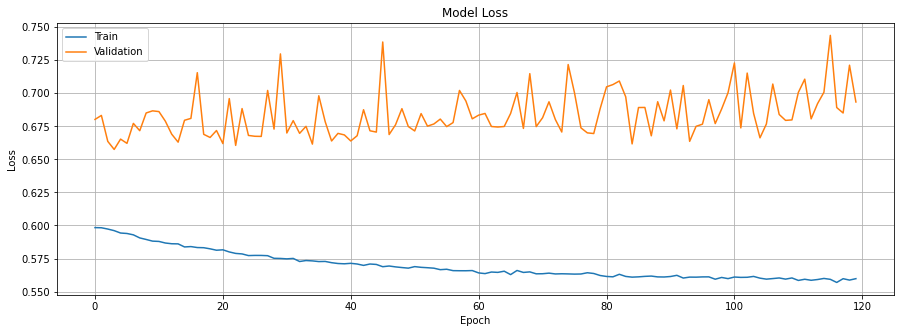

In [104]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

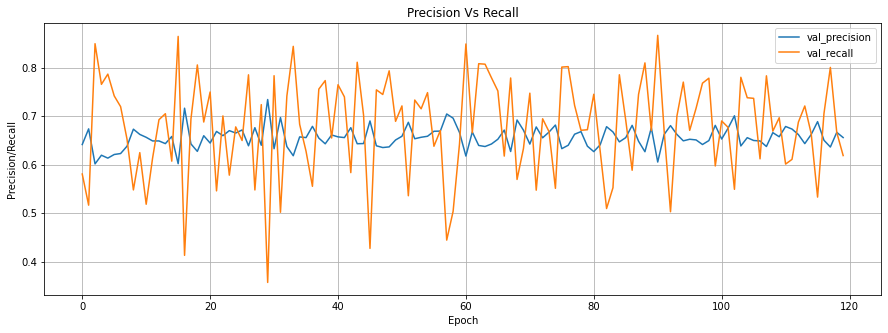

In [105]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

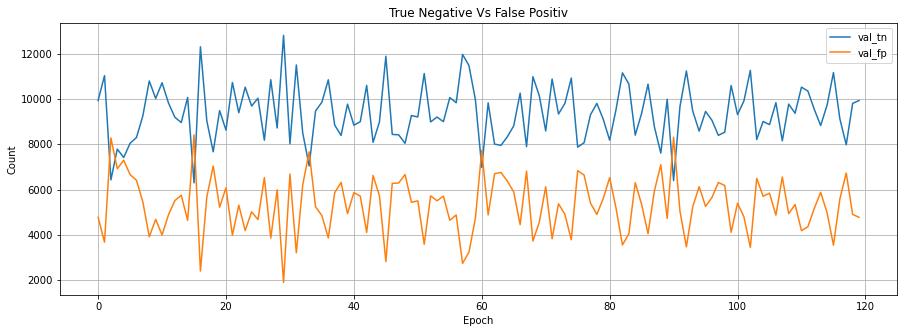

In [106]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [107]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")



predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.7330
Test Accuracy: 0.6764
Test Precision: 0.0823
Test Recall: 0.6069
Test AUC: 0.7002
Test TP: 528
Test FP: 5890
Test TN: 12496
Test FN: 342


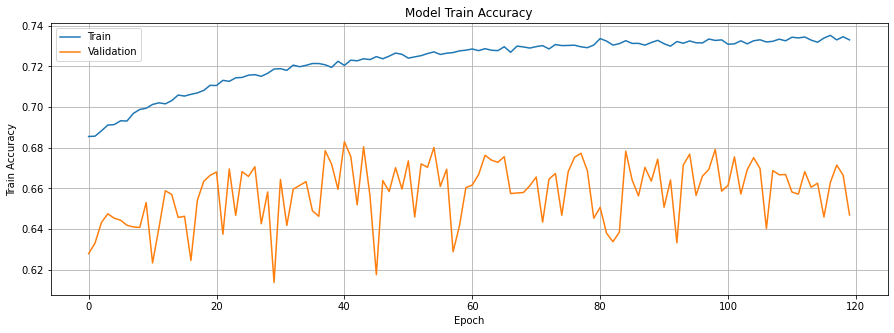

In [108]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [109]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [110]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.5841246843338013
tp :  528.0
fp :  5890.0
tn :  12496.0
fn :  342.0
accuracy :  0.6763606071472168
precision :  0.0822686180472374
recall :  0.6068965792655945
auc :  0.7001795172691345

Non-Seizure Epochs Detected (True Negatives):  12496
Non-Seizure Epochs Incorrectly Detected (False Positives):  5890
Pre-Seizure Epochs Missed (False Negatives):  342
Pre-Seizure Epochs Detected (True Positives):  528
Total Pre-Seizure Epochs:  870


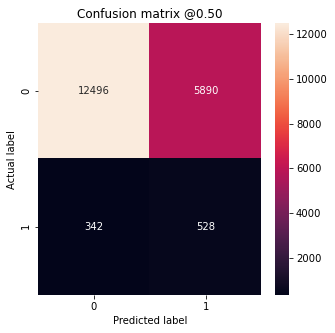

In [111]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

This model's accuracy and recall scores are  relatively good, the model:

- FPR is 32% @0.5
- FNR is 39% @0.5

------------------------------------


The following model is employing Adamax optimizer.

Model pre-12

In [112]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adamax(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

epochs=50

In [124]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=30, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))


peep_me()

Epoch 1/30
3678/3678 [==============================] - 6s 2ms/step - loss: 0.5937 - tp: 46210.0000 - fp: 21098.0000 - tn: 37737.0000 - fn: 12625.0000 - accuracy: 0.7134 - precision: 0.6865 - recall: 0.7854 - auc: 0.7954 - val_loss: 0.7478 - val_tp: 8805.0000 - val_fp: 4589.0000 - val_tn: 10120.0000 - val_fn: 5904.0000 - val_accuracy: 0.6433 - val_precision: 0.6574 - val_recall: 0.5986 - val_auc: 0.7040
Epoch 2/30
3678/3678 [==============================] - 6s 2ms/step - loss: 0.5905 - tp: 46328.0000 - fp: 21026.0000 - tn: 37809.0000 - fn: 12507.0000 - accuracy: 0.7150 - precision: 0.6878 - recall: 0.7874 - auc: 0.7984 - val_loss: 0.7598 - val_tp: 10520.0000 - val_fp: 6244.0000 - val_tn: 8465.0000 - val_fn: 4189.0000 - val_accuracy: 0.6454 - val_precision: 0.6275 - val_recall: 0.7152 - val_auc: 0.6992
Epoch 3/30
3678/3678 [==============================] - 6s 2ms/step - loss: 0.5877 - tp: 46542.0000 - fp: 20911.0000 - tn: 37924.0000 - fn: 12293.0000 - accuracy: 0.7178 - precision: 0.6

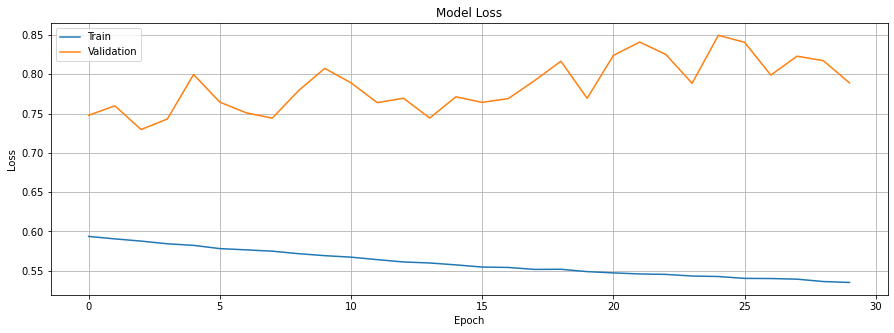

In [125]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

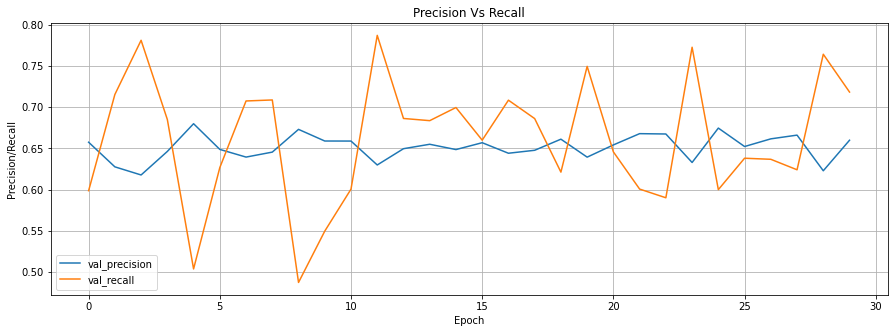

In [126]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

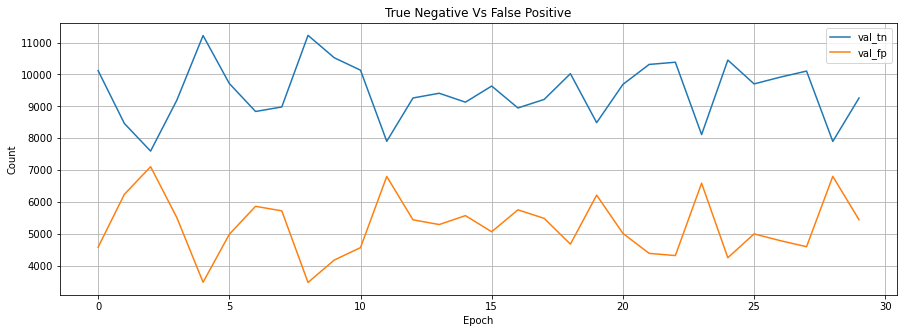

In [127]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [128]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.7638
Test Accuracy: 0.6352
Test Precision: 0.0826
Test Recall: 0.7000
Test AUC: 0.7130
Test TP: 609
Test FP: 6764
Test TN: 11622
Test FN: 261


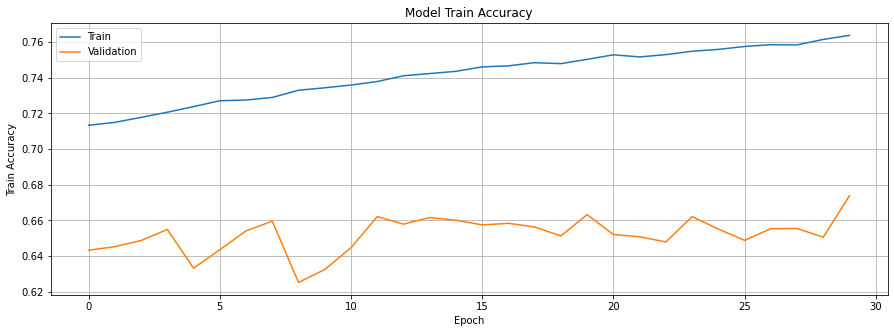

In [129]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [130]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [131]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.6838452219963074
tp :  609.0
fp :  6764.0
tn :  11622.0
fn :  261.0
accuracy :  0.6351786255836487
precision :  0.08259867131710052
recall :  0.699999988079071
auc :  0.7130079865455627

Non-Seizure Epochs Detected (True Negatives):  11622
Non-Seizure Epochs Incorrectly Detected (False Positives):  6764
Pre-Seizure Epochs Missed (False Negatives):  261
Pre-Seizure Epochs Detected (True Positives):  609
Total Pre-Seizure Epochs:  870


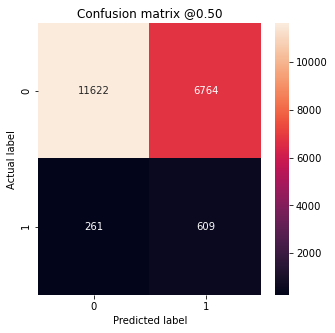

In [132]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The Adamax model was run for 50 epochs, the results are comparables to those of the previous NADAM model but with ~10% better recall.
- FPR is 36%
- FNR is 30%

-----------------------------------------------------------------------------

Now we need to employ an entirely different approach on the features set as so far the results are not as good as they have been anticipated. We may need to include four (2) more previous epochs (seizure epochs) on every observation. the new data frame will be two times wider as much.

We do not need to redo features extraction, we can use the pandas `shift` function to create the new dataframe from the existing one.

In [13]:
df_seizure_w.shape

(96278, 1151)

In [14]:
df_seizure_w.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# use the sift to create a function

This mask does just that, ie finding the indexs where the sizeure happens.

In [94]:
# Add the features for the last 3 epochs and stack them to the curent epoch
# The fastest and most memory inexpensive way is to create 2 new shifted DataFrames and merge them all
# (1 previous epoch is already part of our current dataframe)

In [ ]:
df_1 = df_seizure_w.drop('target', axis=1).shift(periods=1)
df_1.rename(columns='{}_e1'.format, inplace=True)
df_1.columns[0]

In [ ]:
df_2 = df_seizure_w.drop('target', axis=1).shift(periods=2)
df_2.rename(columns='{}_e2'.format, inplace=True)
df_2.columns[0]

In [ ]:
df_3 = df_seizure_w.drop('target', axis=1).shift(periods=3)
df_3.rename(columns='{}_e3'.format, inplace=True)
df_3.columns[0]

Generate a dataframe that only contains the first half of the feature but for the epoch plus the last three epochs.

We already have e_1 in the dataframe when we generated the features

We need to cut the first half of the data frame befor joining them

In [17]:
df_seizure_w.iloc[:,:575].shape

(96278, 575)

In [25]:
df_2 = df_seizure_w.drop('target', axis=1).shift(periods=2)
df_2 = df_2.iloc[:,:575]
df_2.rename(columns='{}_e2'.format, inplace=True)
df_2.columns[0]

'0_e2'

In [26]:
df_2.shape

(96278, 575)

In [27]:
df_3 = df_seizure_w.drop('target', axis=1).shift(periods=3)
df_3 = df_3.iloc[:,:575]
df_3.rename(columns='{}_e3'.format, inplace=True)
df_3.columns[0]

'0_e3'

In [28]:
df_3.shape

(96278, 575)

In [29]:
data_frames = [df_seizure_w, df_2, df_3]

In [30]:
# df_merged = pd.merge(df_seizure_w, df_1, on=index)
df_merged = pd.concat(data_frames, axis=1)

In [31]:
df_merged.head(4)

,0,1,2,3,4,5,6,7,8,9,...,565_e3,566_e3,567_e3,568_e3,569_e3,570_e3,571_e3,572_e3,573_e3,574_e3
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,7.305563e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.036653e-14,5.041897e-14,5.050624e-14,5.062815e-14,5.078444e-14,5.097476e-14,5.119871e-14,5.145580e-14,5.174547e-14,5.206709e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,1.374657e-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_merged = df_merged.iloc[3:]

In [33]:
df_merged.head(4)

,0,1,2,3,4,5,6,7,8,9,...,565_e3,566_e3,567_e3,568_e3,569_e3,570_e3,571_e3,572_e3,573_e3,574_e3
3,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,1.374657e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,1.464056e-13,1.465404e-13,1.467646e-13,1.470777e-13,1.474790e-13,1.479675e-13,1.485421e-13,1.492015e-13,1.499440e-13,1.507679e-13,...,4.083550e-14,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14
5,4.776931e-14,4.781693e-14,4.789618e-14,4.800690e-14,4.814883e-14,4.832166e-14,4.852503e-14,4.875848e-14,4.902151e-14,4.931354e-14,...,3.959594e-14,3.994988e-14,4.032027e-14,4.070628e-14,4.110703e-14,4.152162e-14,4.194912e-14,4.238857e-14,4.283898e-14,4.329934e-14
6,8.748823e-14,8.757053e-14,8.770748e-14,8.789877e-14,8.814396e-14,8.844248e-14,8.879363e-14,8.919660e-14,8.965046e-14,9.015417e-14,...,7.110789e-14,7.171705e-14,7.235416e-14,7.301771e-14,7.370615e-14,7.441785e-14,7.515114e-14,7.590431e-14,7.667558e-14,7.746314e-14


In [34]:
df_merged.to_csv('data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined/' +
                 'seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_half_f.csv')

In [35]:
peep_me()

Read the file from disk

In [4]:
# Read csv file containig the data
path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined'

df_seizure_w = pd.read_csv(
    path + '/' + 'seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_half_f.csv')

peep_me()

In [134]:
df_seizure_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96275 entries, 0 to 96274
Columns: 2302 entries, Unnamed: 0 to 574_e3
dtypes: float64(2301), int64(1)
memory usage: 1.7 GB


In [ ]:
df_seizure_w.head(2)

In [5]:
df_seizure_w = df_seizure_w.loc[:, ~df_seizure_w.columns.str.contains('^Unnamed')]
df_seizure_w.head(2)

,0,1,2,3,4,5,6,7,8,9,...,565_e3,566_e3,567_e3,568_e3,569_e3,570_e3,571_e3,572_e3,573_e3,574_e3
0,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,1.374657e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.464056e-13,1.465404e-13,1.467646e-13,1.470777e-13,1.474790e-13,1.479675e-13,1.485421e-13,1.492015e-13,1.499440e-13,1.507679e-13,...,4.083550e-14,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14


Delete the first 3 Nan rows

In [6]:
df_seizure_w['target'].value_counts()

0.0    91927
1.0     4348
Name: target, dtype: int64

In [7]:
df_seizure_w.shape

(96275, 2301)

Separate x and y

In [8]:
# path = 'data/dataset_2'
# combined_files_path = 'combined_files'

# print(f'Reading file.......................................', end='\r')
# df_seizure_w = pd.read_csv(path + '/' + combined_files_path + '/' + 'seizure_w_ds2_3s_280321_full.csv')

# Separate x and y
X = df_seizure_w.drop('target', axis=1)
y = df_seizure_w['target']

Release memory

In [164]:
import gc

del [[df_seizure_w]]
gc.collect()
df_seizure_w=pd.DataFrame()

Split data

In [9]:
# split into train/Val and test before SMOTE
from sklearn.model_selection import train_test_split

print(f'Splitting data into train/Val and test before SMOTE..........', end='\r')
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# split into train and val before SMOTE
print(f'Splitting data into train and val before SMOTE..........', end='\r')
X_train, X_val, y_train, y_val= train_test_split(X_remain, y_remain, test_size=0.2, stratify=y_remain, random_state=1)
print()
peep_me()

Splitting data into train and val before SMOTE...............


In [165]:
import gc

del [[X,y]]
gc.collect()
X = []
y = []

In [172]:
X_train.shape

(61616, 2300)

SMOTE data

In [10]:
import imblearn
from imblearn.over_sampling import SMOTE

print(f'SMOTE operation ...................................................', end='\r')
# 100% SMOTE strategy
strategy = {0.0:y_train.value_counts()[0], 1.0:(y_train.value_counts()[0]).astype(int)}
oversample = SMOTE(sampling_strategy=strategy, random_state = 1)  # 100% oversampling
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

strategy = {0.0:y_val.value_counts()[0], 1.0:(y_val.value_counts()[0]).astype(int)}
oversample = SMOTE(sampling_strategy=strategy, random_state = 1)  # 100% oversampling
X_val_os, y_val_os = oversample.fit_resample(X_val, y_val) #?????????????????????????
print()
peep_me()

SMOTE operation ...................................................


Scale data

In [11]:
# use standard scaler for the first pass
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

print(f'Scaling patient data..................................', end='\r')
# scale data - train + test, first fit
standard_scaler.fit(X_train_os)
X_train_os_ss = standard_scaler.transform(X_train_os)
X_val_os_ss = standard_scaler.transform(X_val_os)
X_test_ss = standard_scaler.transform(X_test)
print()
peep_me()

Scaling patient data..................................


PCA data

In [12]:
# PCA first to look at the data - reduce dimensions
from sklearn.decomposition import PCA

print(f'PCA operation on data.........................', end='\r')
# fit and transform
pca = PCA(n_components=X_train_os_ss.shape[1])
pca.fit(X_train_os_ss)  # _ss is scaled data
X_train_os_ss_PCA = pca.transform(X_train_os_ss)
X_val_os_ss_PCA = pca.transform(X_val_os_ss)
X_test_ss_PCA = pca.transform(X_test_ss)

expl_var = pca.explained_variance_ratio_
pca_expl_var = np.cumsum(expl_var)[10]
print()
peep_me()
print(f'{pca_expl_var}.............')

PCA operation on data.........................
0.9476552486015224.............


In [13]:
# extract the first 10 dimensions only
# fit and transform
pca = PCA(n_components=10)
pca.fit(X_train_os_ss) # _ss is scaled data
X_train_os_ss_PCA10 = pca.transform(X_train_os_ss)
X_val_os_ss_PCA10 = pca.transform(X_val_os_ss)
X_test_ss_PCA10 = pca.transform(X_test_ss)

peep_me()

Save the Prediction model preprocessing pickles

In [46]:
# Save PCA and scaler as pickles
import joblib
standard_scaler_file = 'data/joblib/ss_e_to_e3_050421.joblib'
pca_file = 'data/joblib/pca10_e_to_e3_050421.joblib'
joblib.dump(standard_scaler, standard_scaler_file) 
joblib.dump(pca, pca_file) 

['data/joblib/pca10_e_to_e3_050421.joblib']

Plot Pca

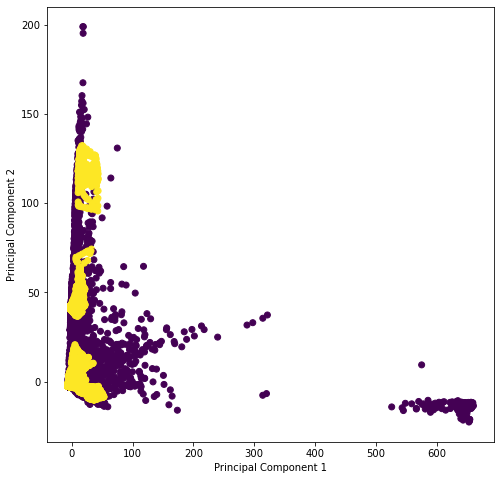

In [152]:
# Plotting the PCA data
plt.figure(figsize=(8, 8))
plt.scatter(X_train_os_ss_PCA10[:,0],X_train_os_ss_PCA10[:,1],c=y_train_os)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()

This PCA shows clustering of our positive class and high overlap with class zero except for the upper cluster, still, it is likely the model will be able to pick the class with acceptable confidence.

The lone class zero cluster on the right likely belongs to one patient.

In [ ]:
# save arrays, these need to be PCed first before being used in modelling

path = 'data/dataset_2/freq_dom_nbc_data_3s/combined_files_preictal_3/combined/'

np.savetxt(path + "seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_X_train_os_ss.csv",
           X_train_os_ss, delimiter=",")
np.savetxt(path + "seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_X_val_os_ss.csv",
           X_val_os_ss, delimiter=",")
np.savetxt(path + "seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_X_test_ss.csv",
           X_test_ss, delimiter=",")

np.savetxt(path + "seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_y_train_os.csv",
           y_train_os, delimiter=",")
np.savetxt(path + "seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_y_val_os.csv",
           y_val_os, delimiter=",")
np.savetxt(path + "seizure_w_ds2_3s_full_preictal_2classes_plus_3_prev_epoch_y_test.csv",
           y_test, delimiter=",")

Now let us do the modelling.

Model pre-14

In [48]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adamax(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [70]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=50, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

# # Save model as pickle
# import joblib
# nn_model_file = 'data/joblib/nn_model_22.joblib'
# joblib.dump(model, nn_model_file)

peep_me()

Epoch 1/50
3678/3678 [==============================] - 7s 2ms/step - loss: 0.4692 - tp: 50928.0000 - fp: 13803.0000 - tn: 45031.0000 - fn: 7906.0000 - accuracy: 0.8155 - precision: 0.7868 - recall: 0.8656 - auc: 0.9021 - val_loss: 0.7729 - val_tp: 9922.0000 - val_fp: 3080.0000 - val_tn: 11628.0000 - val_fn: 4786.0000 - val_accuracy: 0.7326 - val_precision: 0.7631 - val_recall: 0.6746 - val_auc: 0.8106
Epoch 2/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.4680 - tp: 50960.0000 - fp: 13639.0000 - tn: 45195.0000 - fn: 7874.0000 - accuracy: 0.8172 - precision: 0.7889 - recall: 0.8662 - auc: 0.9028 - val_loss: 0.7697 - val_tp: 12164.0000 - val_fp: 5289.0000 - val_tn: 9419.0000 - val_fn: 2544.0000 - val_accuracy: 0.7337 - val_precision: 0.6970 - val_recall: 0.8270 - val_auc: 0.8108
Epoch 3/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.4658 - tp: 51004.0000 - fp: 13662.0000 - tn: 45172.0000 - fn: 7830.0000 - accuracy: 0.8174 - precision: 0.7887

3678/3678 [==============================] - 6s 2ms/step - loss: 0.4269 - tp: 52143.0000 - fp: 11707.0000 - tn: 47127.0000 - fn: 6691.0000 - accuracy: 0.8436 - precision: 0.8166 - recall: 0.8863 - auc: 0.9258 - val_loss: 0.8113 - val_tp: 10589.0000 - val_fp: 2998.0000 - val_tn: 11710.0000 - val_fn: 4119.0000 - val_accuracy: 0.7581 - val_precision: 0.7793 - val_recall: 0.7199 - val_auc: 0.8283
Epoch 42/50
3678/3678 [==============================] - 7s 2ms/step - loss: 0.4276 - tp: 52174.0000 - fp: 11774.0000 - tn: 47060.0000 - fn: 6660.0000 - accuracy: 0.8433 - precision: 0.8159 - recall: 0.8868 - auc: 0.9255 - val_loss: 0.7598 - val_tp: 11433.0000 - val_fp: 3821.0000 - val_tn: 10887.0000 - val_fn: 3275.0000 - val_accuracy: 0.7588 - val_precision: 0.7495 - val_recall: 0.7773 - val_auc: 0.8210
Epoch 43/50
3678/3678 [==============================] - 8s 2ms/step - loss: 0.4272 - tp: 52128.0000 - fp: 11665.0000 - tn: 47169.0000 - fn: 6706.0000 - accuracy: 0.8439 - precision: 0.8171 - reca

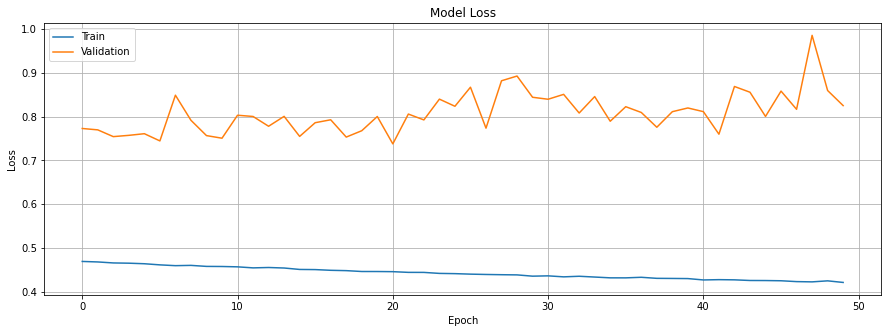

In [71]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

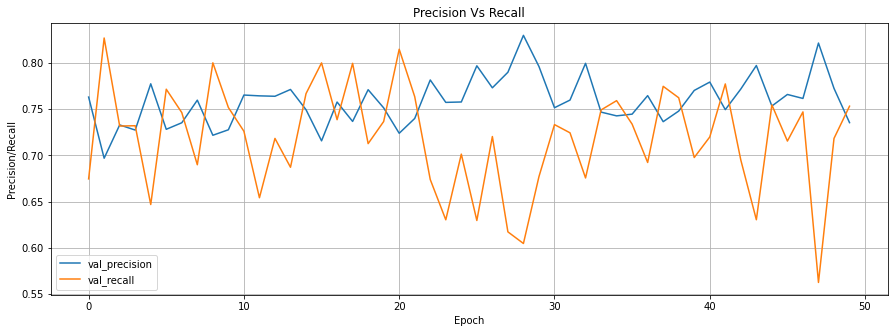

In [72]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

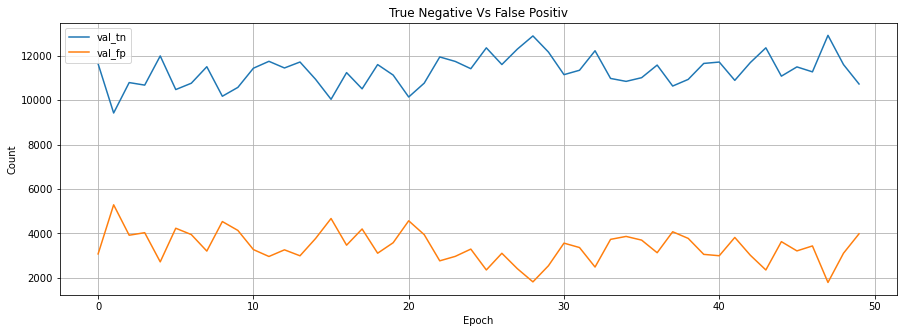

In [73]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [74]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")



predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.8478
Test Accuracy: 0.7338
Test Precision: 0.1104
Test Recall: 0.6931
Test AUC: 0.7768
Test TP: 603
Test FP: 4858
Test TN: 13527
Test FN: 267


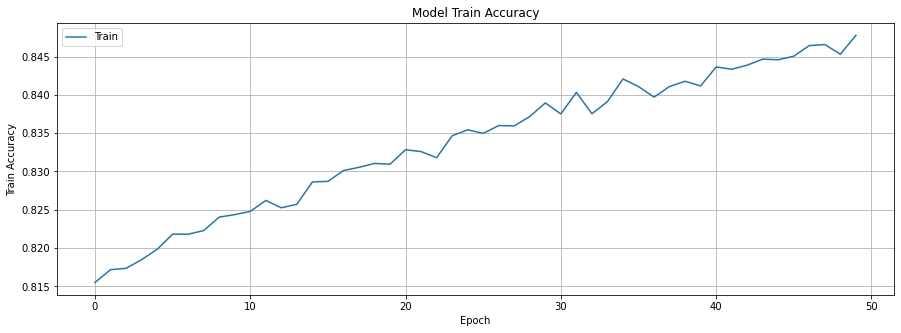

In [75]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [76]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [77]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.6082557439804077
tp :  603.0
fp :  4858.0
tn :  13527.0
fn :  267.0
accuracy :  0.7338353395462036
precision :  0.11041934043169022
recall :  0.6931034326553345
auc :  0.7768361568450928

Non-Seizure Epochs Detected (True Negatives):  13527
Non-Seizure Epochs Incorrectly Detected (False Positives):  4858
Pre-Seizure Epochs Missed (False Negatives):  267
Pre-Seizure Epochs Detected (True Positives):  603
Total Pre-Seizure Epochs:  870


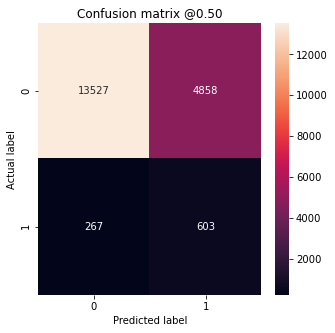

In [78]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

These results of these 4-epochs observations relu and adamx model are clearly a significant improvement compared to the previous models using 2-epochs observations.
- epochs = 50
- accuracy :  0.73
- precision :  0.11
- recall :  0.69

- FPR is 26.4% @0.5
- FNR is  30.7% @0.5

In [76]:
# Save model
model.save('data/joblib/keras/predict_pre_14b/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: data/joblib/keras/predict_pre_14b/assets


-------------------------------------------

The following model employs adam instead of Adamax optimizer and 3 10% dropout layers have been added.

Model pre-15

In [137]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.01)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [138]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=50, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

# # Save model as pickle
# import joblib
# nn_model_file = 'data/joblib/nn_model_22.joblib'
# joblib.dump(model, nn_model_file)

peep_me()

Epoch 1/50
3678/3678 [==============================] - 10s 3ms/step - loss: 0.8024 - tp: 43808.0000 - fp: 35187.0000 - tn: 23647.0000 - fn: 15026.0000 - accuracy: 0.5733 - precision: 0.5546 - recall: 0.7446 - auc: 0.5938 - val_loss: 0.6823 - val_tp: 12254.0000 - val_fp: 10230.0000 - val_tn: 4478.0000 - val_fn: 2454.0000 - val_accuracy: 0.5688 - val_precision: 0.5450 - val_recall: 0.8332 - val_auc: 0.6186
Epoch 2/50
3678/3678 [==============================] - 10s 3ms/step - loss: 0.6793 - tp: 44218.0000 - fp: 34725.0000 - tn: 24109.0000 - fn: 14616.0000 - accuracy: 0.5807 - precision: 0.5601 - recall: 0.7516 - auc: 0.6069 - val_loss: 0.6780 - val_tp: 11925.0000 - val_fp: 9360.0000 - val_tn: 5348.0000 - val_fn: 2783.0000 - val_accuracy: 0.5872 - val_precision: 0.5603 - val_recall: 0.8108 - val_auc: 0.6276
Epoch 3/50
3678/3678 [==============================] - 10s 3ms/step - loss: 0.6768 - tp: 43524.0000 - fp: 33709.0000 - tn: 25125.0000 - fn: 15310.0000 - accuracy: 0.5834 - precision:

3678/3678 [==============================] - 12s 3ms/step - loss: 0.6702 - tp: 42352.0000 - fp: 31940.0000 - tn: 26894.0000 - fn: 16482.0000 - accuracy: 0.5885 - precision: 0.5701 - recall: 0.7199 - auc: 0.6195 - val_loss: 0.6738 - val_tp: 12386.0000 - val_fp: 10189.0000 - val_tn: 4519.0000 - val_fn: 2322.0000 - val_accuracy: 0.5747 - val_precision: 0.5487 - val_recall: 0.8421 - val_auc: 0.6383
Epoch 42/50
3678/3678 [==============================] - 12s 3ms/step - loss: 0.6695 - tp: 42697.0000 - fp: 32202.0000 - tn: 26632.0000 - fn: 16137.0000 - accuracy: 0.5892 - precision: 0.5701 - recall: 0.7257 - auc: 0.6223 - val_loss: 0.6738 - val_tp: 12545.0000 - val_fp: 10267.0000 - val_tn: 4441.0000 - val_fn: 2163.0000 - val_accuracy: 0.5774 - val_precision: 0.5499 - val_recall: 0.8529 - val_auc: 0.6363
Epoch 43/50
3678/3678 [==============================] - 12s 3ms/step - loss: 0.6698 - tp: 42629.0000 - fp: 32276.0000 - tn: 26558.0000 - fn: 16205.0000 - accuracy: 0.5880 - precision: 0.5691 

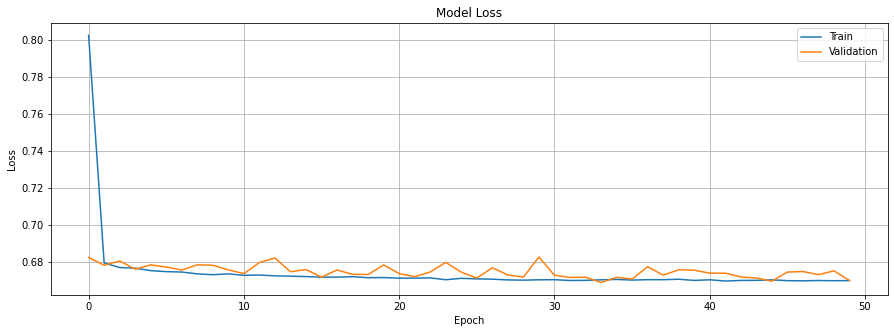

In [139]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

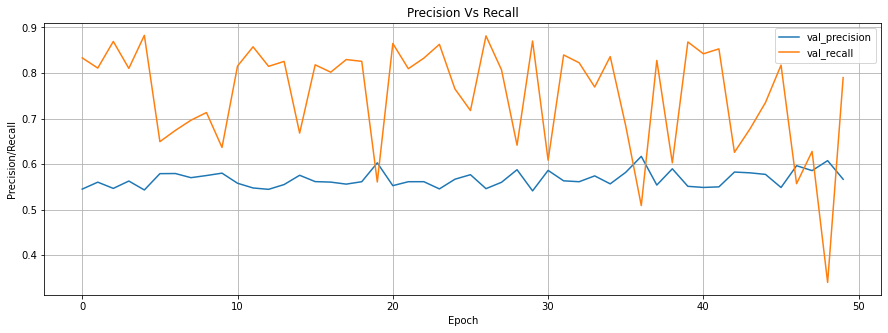

In [140]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

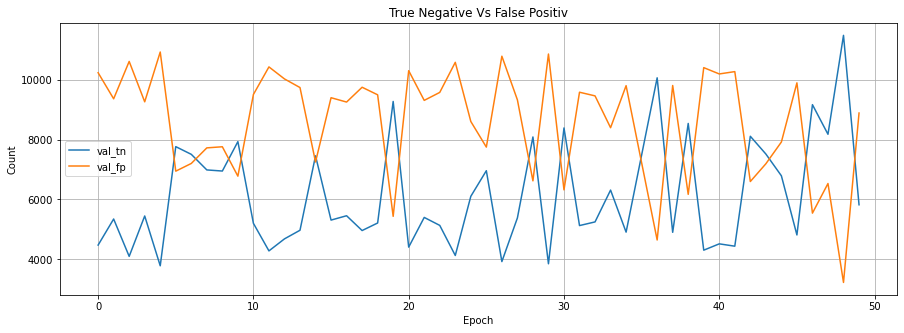

In [141]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [142]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")



predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.5901
Test Accuracy: 0.4205
Test Precision: 0.0572
Test Recall: 0.7644
Test AUC: 0.6221
Test TP: 665
Test FP: 10954
Test TN: 7431
Test FN: 205


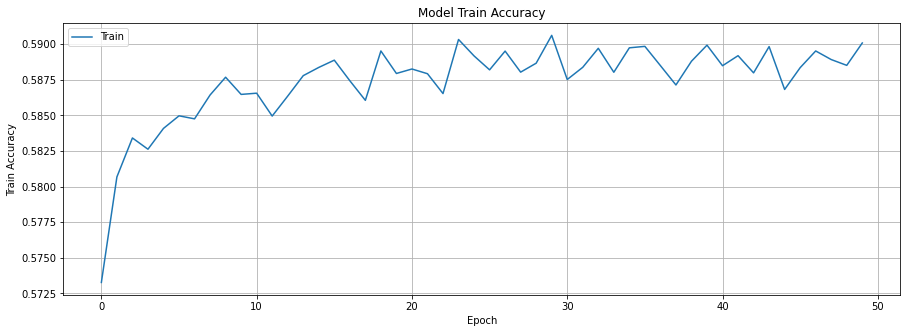

In [143]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [144]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [147]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.68631911277771
tp :  665.0
fp :  10954.0
tn :  7431.0
fn :  205.0
accuracy :  0.4204622209072113
precision :  0.057233840227127075
recall :  0.7643678188323975
auc :  0.6221338510513306

Non-Seizure Epochs Detected (True Negatives):  7431
Non-Seizure Epochs Incorrectly Detected (False Positives):  10954
Pre-Seizure Epochs Missed (False Negatives):  205
Pre-Seizure Epochs Detected (True Positives):  665
Total Pre-Seizure Epochs:  870


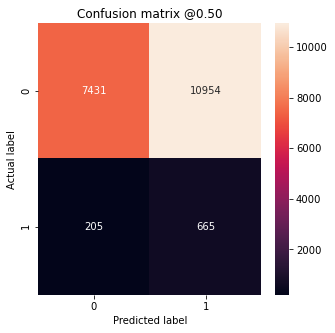

In [148]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

On this model, 50 epochs were run but the change of the optimizer and the addition of the dropout layers did not improve the results. All metrics are lower than the previous model. Notice the high false positives on the confusion matrix!

# Summary

The optimization has been done manually for this network. The regularization was changed from 0.001 to 0.01 and 0.0001 but similar to the detection problem, it was either inducing overfitting or causing an increase in the false-positive after the first few epochs, the code of which was omitted from the notebook as the fitting was stopped early.

The model optimization was mainly done for the 2-epochs data but the best results were obtained when the 4-epoch data was used.
The best performing model (model pre-14) resulted in the following parameters and metrics:

- Adamax optimizer.
- relu activation function.
- structure:  5 hidden layers
- epochs = 50
- accuracy : 0.73
- precision : 0.11
- recall : 0.69
- FPR is 26.4% @0.5
- FNR is 30.7% @0.5


What could have been done better on the model's optimization:
- Probably using an automated pipe could have resulted in a better combination of the hyperparameters especially on the prediction model optimization
- k-fold cross validation would have added to the confidence in the results. Although the literature stated that this wasn't followed on the subject matter religiously in a considerable amount of research work,  cross-validation is something to consider when the work is refined.